In [ ]:
import os
import math
import shap
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Defining some useful variables

# Set the project folder
PRJ_FOLDER = '.'
# Set the folder the full dataset is located
DATA_FOLDER = os.path.join(PRJ_FOLDER, 'data')
# Set the name of the file that holds the full dataset
FULL_DATASET_NAME = 'full.csv'
# Set "No Audio" dataset
NO_AUDIO_DATASET_NAME = 'no_audio_corrected.csv'
# Set the name of the file that holds the angraphic information
LABELS_NAME = 'labels.csv'

TOP_K = 16

# Load the labels only once, in order to reuse them
LABELS = pd.read_csv(os.path.join(DATA_FOLDER, LABELS_NAME))

# SMOTE Upsampler
SMOTE = BorderlineSMOTE()


print(f'Folder where the entire project is located: {PRJ_FOLDER}')
print(f'Folder where the full dataset is saved: {DATA_FOLDER}')
print(f'Name of the full dataset: {FULL_DATASET_NAME}')
print(f'Name of the anagraphic dataset: {LABELS_NAME}')

Folder where the entire project is located: .
Folder where the full dataset is saved: .\data
Name of the full dataset: full.csv
Name of the anagraphic dataset: labels.csv


In [3]:
# Let's define a simple function that loads a single dataset

def load_raw_data(csv_path: str, feat_to_predict: str):
    # Load the entire csv file
    data = pd.read_csv(csv_path)

    # Join labels and data so that truth values are aligned with original data
    lbls = LABELS[['id', feat_to_predict]]
    temp = data.merge(lbls, on='id', how='left')
    temp = temp.dropna()
    # Extract only the ground truths
    labels = pd.DataFrame(temp[feat_to_predict], columns=[feat_to_predict])
    data = temp.drop(feat_to_predict, axis=1)
    data = data.set_index('id')
    data = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns, index=data.index)

    #return data.to_numpy(), labels.to_numpy().reshape((len(labels), ))
    return data, labels

In [4]:
def plot_best_feat(feats, scores, yerr=None, title: str = '', dimensions=(10,8)):
    plt.rcParams["figure.figsize"] = dimensions

    feats, scores = list(reversed(feats)), list(reversed(scores))

    if yerr:
        plt.barh(feats, scores, yerr=yerr, capsize=6)
    else:
        plt.barh(feats, scores)
    plt.title(title)
    plt.xlabel('Score')
    plt.show()
    print(feats[::-1])

In [5]:
def plot_compounded(folds, title, dimensions=(10, 12)):
    plt.rcParams["figure.figsize"] = dimensions
    
    count = {}
    for feats, _ in folds:
        for feat in feats:
            if feat not in count:
                count[feat] = 0
            count[feat] += 1
    comp = sorted(list(count.items()), key=(lambda x: x[1]), reverse=True)
    feats, freqs = zip(*comp[:30])
    feats, freqs = list(reversed(list(feats))), list(reversed(list(freqs)))
    
    plt.barh(feats, freqs)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.show()
    print(feats[::-1])


# ML Approach

In [224]:
def ml_analysis(feat_to_predict, audio=True):
    PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME if audio else NO_AUDIO_DATASET_NAME)

    X, y = load_raw_data(PATH, feat_to_predict)
    results = []
    for _ in range(100):
        X_train, __, y_train, __ = train_test_split(X, y, test_size=0.2, stratify=y)
        X_train, y_train = SMOTE.fit_resample(X_train, y_train)
        
        sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
        sel.fit(X_train, y_train)

        support = sel.get_support()
        selected_feat = X.columns[support].tolist()
        selected_importances = sel.estimator_.feature_importances_.ravel()
        
        final_sorted = sorted(list(zip(selected_feat, selected_importances)), key=(lambda x: x[1]), reverse=True)
        feats, importances = zip(*(final_sorted[:TOP_K]))
        results.append((feats, importances))

    plot_compounded(results, feat_to_predict)


### Full Data

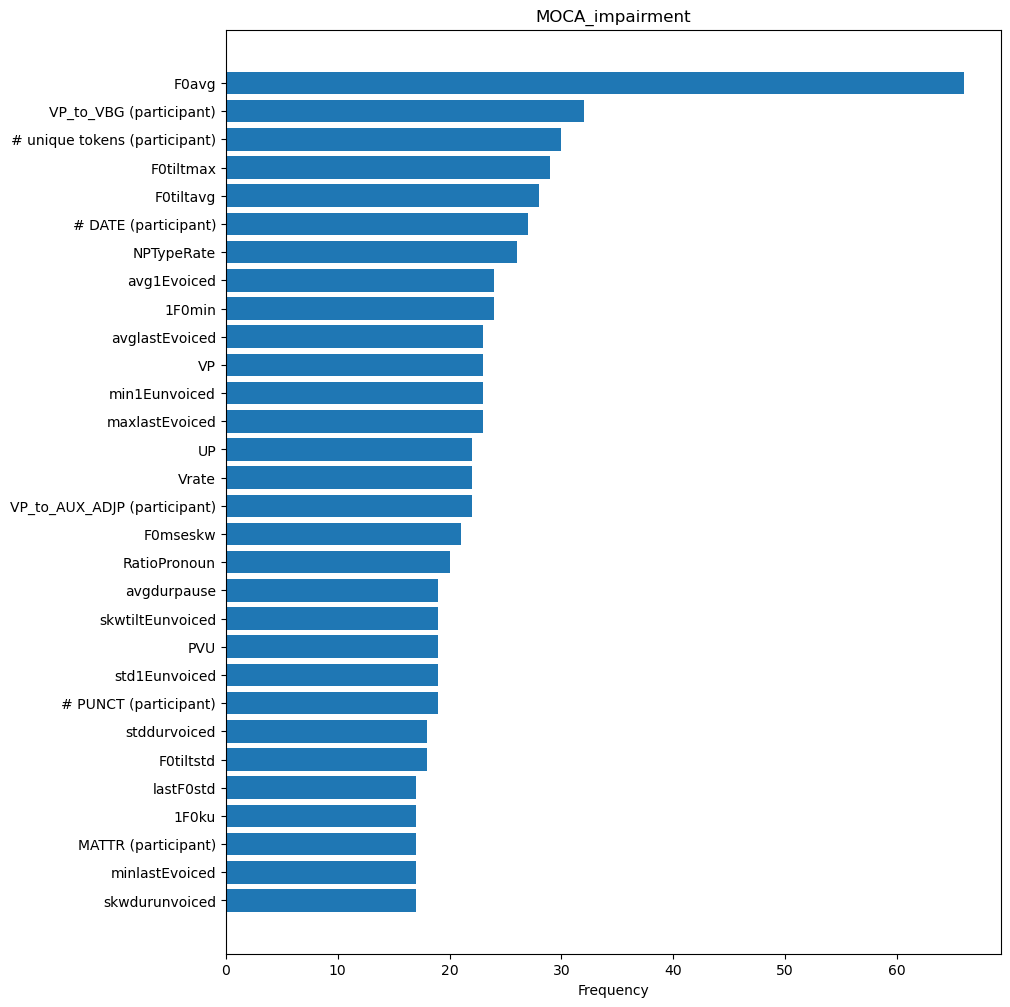

['F0avg', 'VP_to_VBG (participant)', '# unique tokens (participant)', 'F0tiltmax', 'F0tiltavg', '# DATE (participant)', 'NPTypeRate', 'avg1Evoiced', '1F0min', 'avglastEvoiced', 'VP', 'min1Eunvoiced', 'maxlastEvoiced', 'UP', 'Vrate', 'VP_to_AUX_ADJP (participant)', 'F0mseskw', 'RatioPronoun', 'avgdurpause', 'skwtiltEunvoiced', 'PVU', 'std1Eunvoiced', '# PUNCT (participant)', 'stddurvoiced', 'F0tiltstd', 'lastF0std', '1F0ku', 'MATTR (participant)', 'minlastEvoiced', 'skwdurunvoiced']


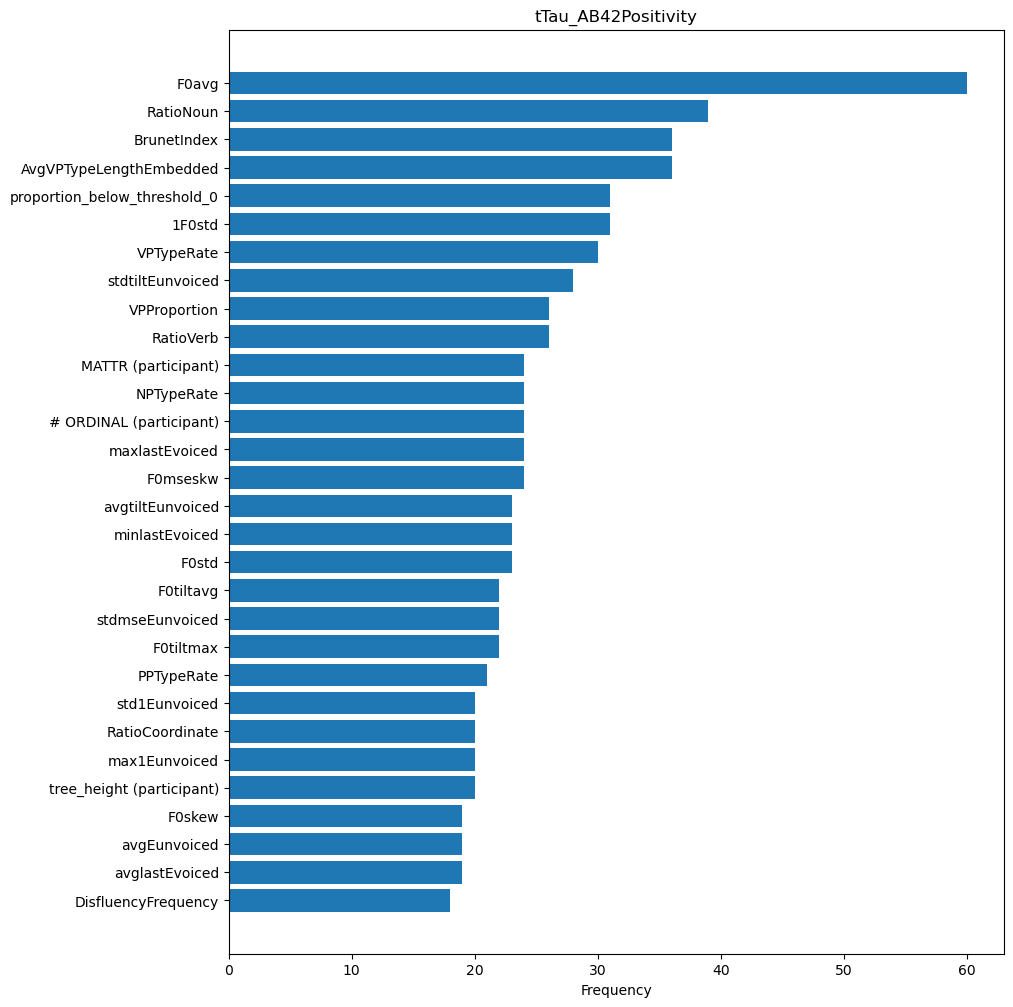

['F0avg', 'RatioNoun', 'BrunetIndex', 'AvgVPTypeLengthEmbedded', 'proportion_below_threshold_0', '1F0std', 'VPTypeRate', 'stdtiltEunvoiced', 'VPProportion', 'RatioVerb', 'MATTR (participant)', 'NPTypeRate', '# ORDINAL (participant)', 'maxlastEvoiced', 'F0mseskw', 'avgtiltEunvoiced', 'minlastEvoiced', 'F0std', 'F0tiltavg', 'stdmseEunvoiced', 'F0tiltmax', 'PPTypeRate', 'std1Eunvoiced', 'RatioCoordinate', 'max1Eunvoiced', 'tree_height (participant)', 'F0skew', 'avgEunvoiced', 'avglastEvoiced', 'DisfluencyFrequency']


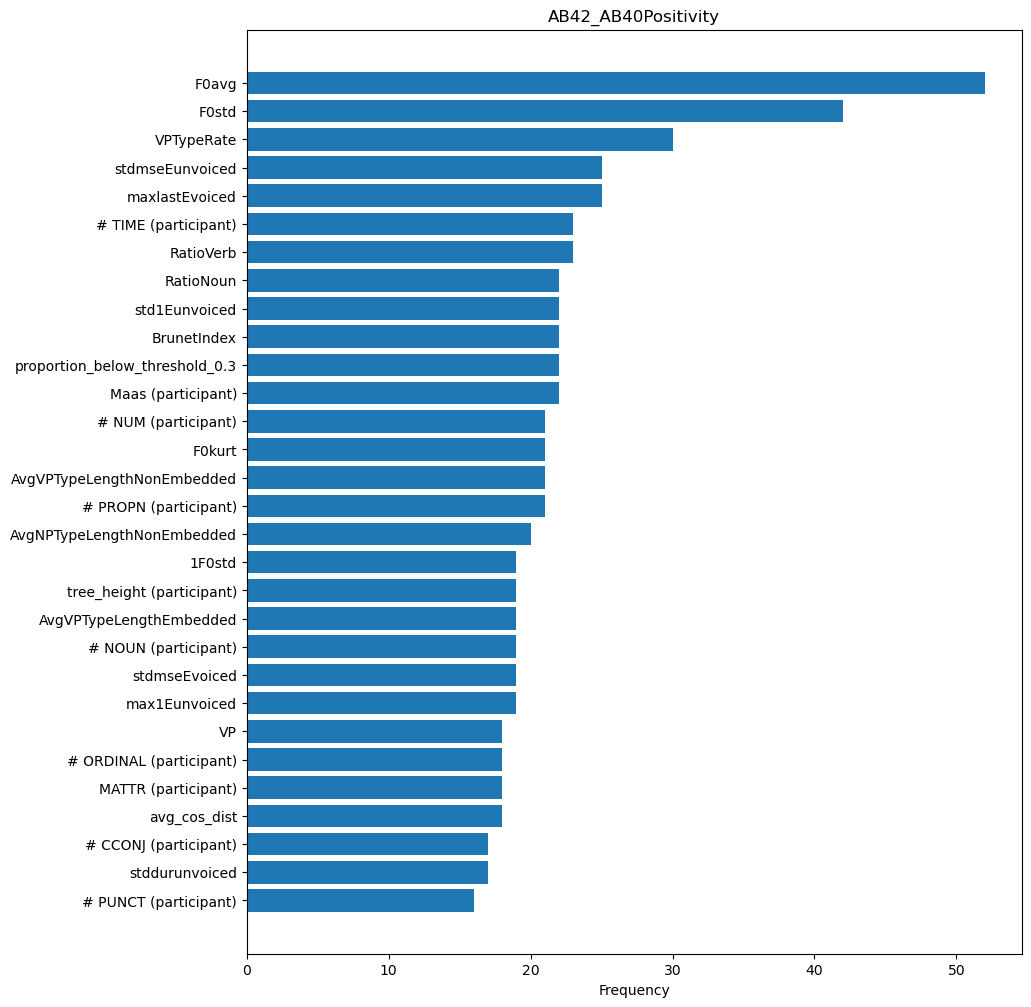

['F0avg', 'F0std', 'VPTypeRate', 'stdmseEunvoiced', 'maxlastEvoiced', '# TIME (participant)', 'RatioVerb', 'RatioNoun', 'std1Eunvoiced', 'BrunetIndex', 'proportion_below_threshold_0.3', 'Maas (participant)', '# NUM (participant)', 'F0kurt', 'AvgVPTypeLengthNonEmbedded', '# PROPN (participant)', 'AvgNPTypeLengthNonEmbedded', '1F0std', 'tree_height (participant)', 'AvgVPTypeLengthEmbedded', '# NOUN (participant)', 'stdmseEvoiced', 'max1Eunvoiced', 'VP', '# ORDINAL (participant)', 'MATTR (participant)', 'avg_cos_dist', '# CCONJ (participant)', 'stddurunvoiced', '# PUNCT (participant)']


In [7]:
ml_analysis('MOCA_impairment')
ml_analysis('tTau_AB42Positivity')
ml_analysis('AB42_AB40Positivity')

### No Audio

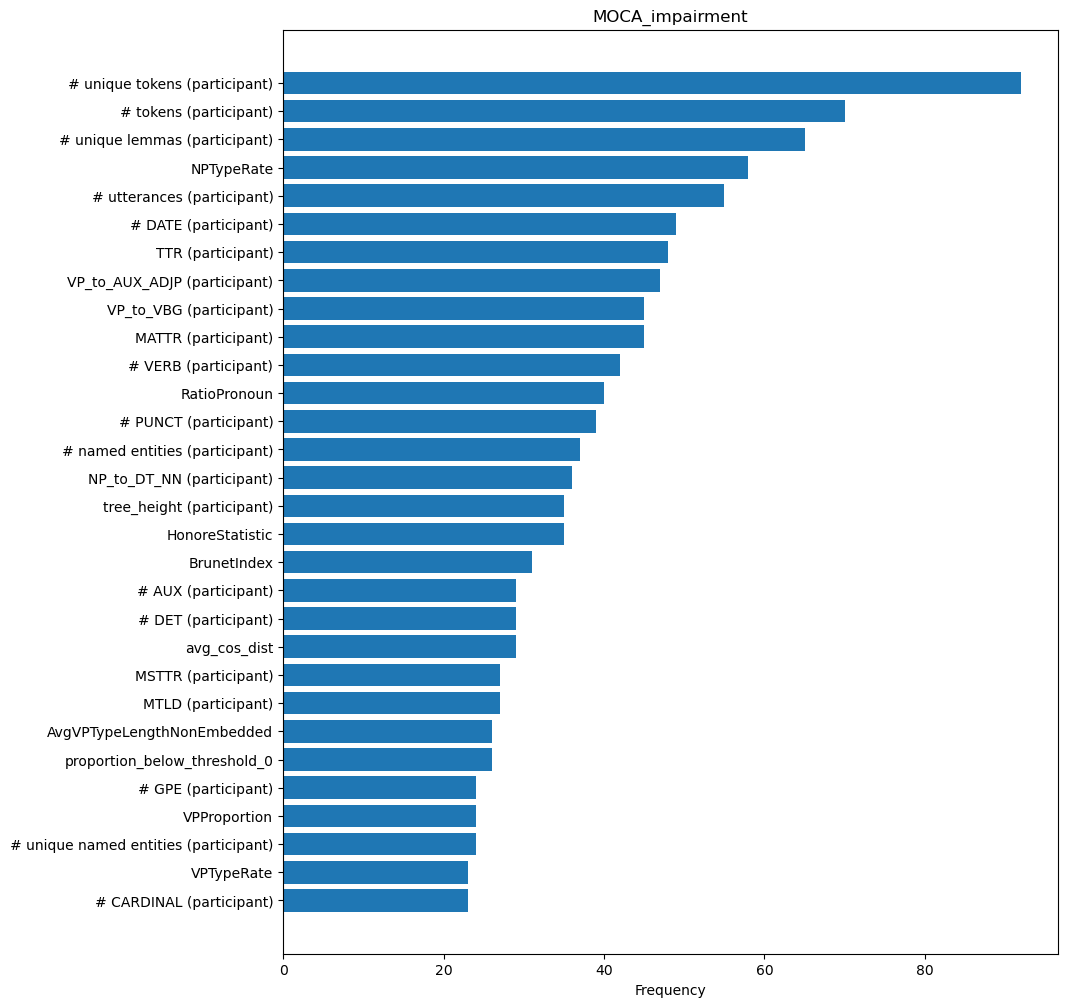

['# unique tokens (participant)', '# tokens (participant)', '# unique lemmas (participant)', 'NPTypeRate', '# utterances (participant)', '# DATE (participant)', 'TTR (participant)', 'VP_to_AUX_ADJP (participant)', 'VP_to_VBG (participant)', 'MATTR (participant)', '# VERB (participant)', 'RatioPronoun', '# PUNCT (participant)', '# named entities (participant)', 'NP_to_DT_NN (participant)', 'tree_height (participant)', 'HonoreStatistic', 'BrunetIndex', '# AUX (participant)', '# DET (participant)', 'avg_cos_dist', 'MSTTR (participant)', 'MTLD (participant)', 'AvgVPTypeLengthNonEmbedded', 'proportion_below_threshold_0', '# GPE (participant)', 'VPProportion', '# unique named entities (participant)', 'VPTypeRate', '# CARDINAL (participant)']


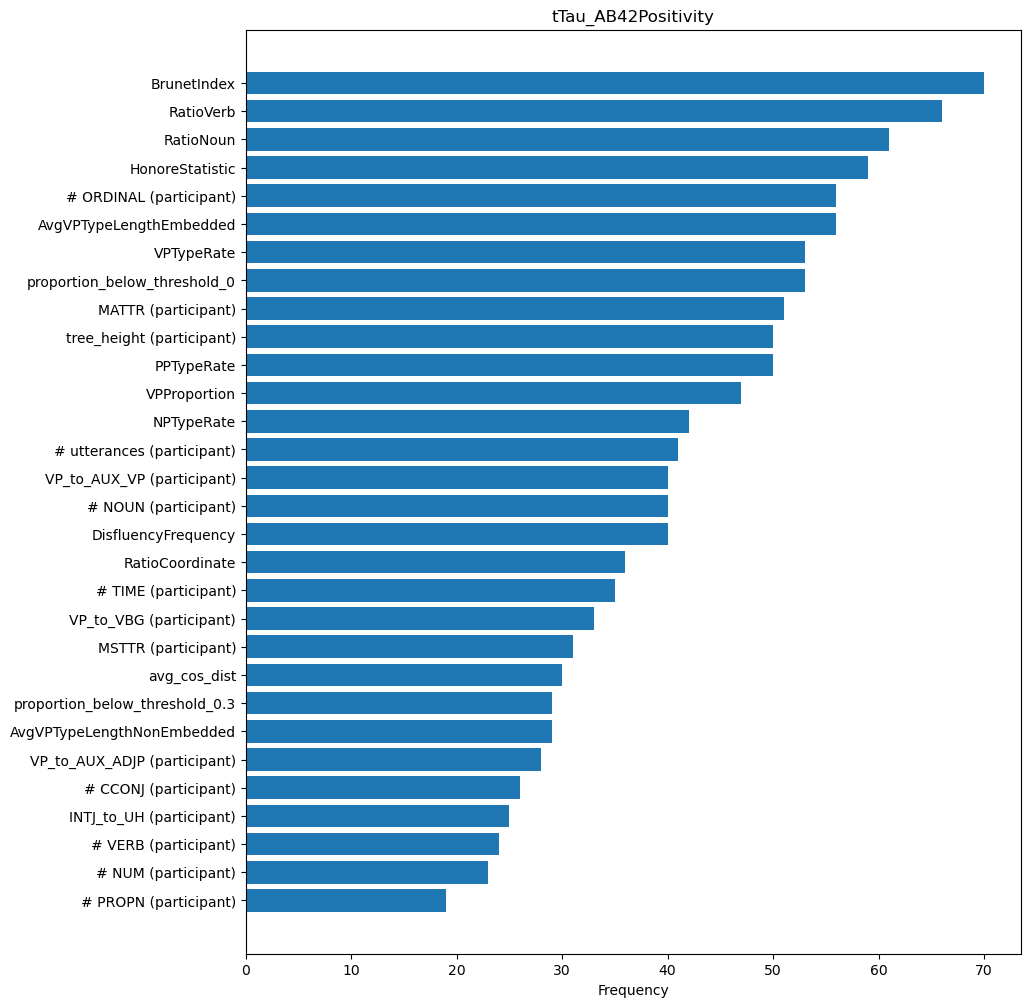

['BrunetIndex', 'RatioVerb', 'RatioNoun', 'HonoreStatistic', '# ORDINAL (participant)', 'AvgVPTypeLengthEmbedded', 'VPTypeRate', 'proportion_below_threshold_0', 'MATTR (participant)', 'tree_height (participant)', 'PPTypeRate', 'VPProportion', 'NPTypeRate', '# utterances (participant)', 'VP_to_AUX_VP (participant)', '# NOUN (participant)', 'DisfluencyFrequency', 'RatioCoordinate', '# TIME (participant)', 'VP_to_VBG (participant)', 'MSTTR (participant)', 'avg_cos_dist', 'proportion_below_threshold_0.3', 'AvgVPTypeLengthNonEmbedded', 'VP_to_AUX_ADJP (participant)', '# CCONJ (participant)', 'INTJ_to_UH (participant)', '# VERB (participant)', '# NUM (participant)', '# PROPN (participant)']


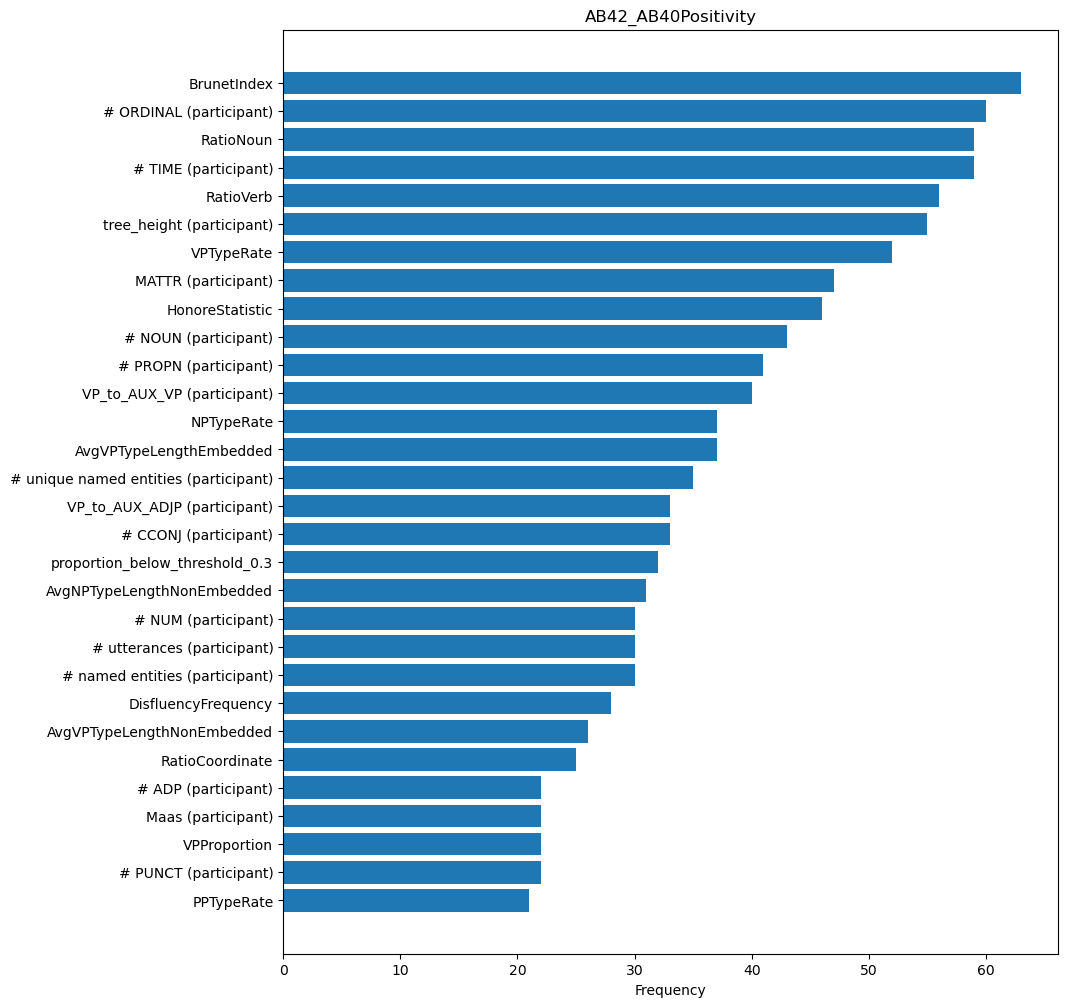

['BrunetIndex', '# ORDINAL (participant)', 'RatioNoun', '# TIME (participant)', 'RatioVerb', 'tree_height (participant)', 'VPTypeRate', 'MATTR (participant)', 'HonoreStatistic', '# NOUN (participant)', '# PROPN (participant)', 'VP_to_AUX_VP (participant)', 'NPTypeRate', 'AvgVPTypeLengthEmbedded', '# unique named entities (participant)', 'VP_to_AUX_ADJP (participant)', '# CCONJ (participant)', 'proportion_below_threshold_0.3', 'AvgNPTypeLengthNonEmbedded', '# NUM (participant)', '# utterances (participant)', '# named entities (participant)', 'DisfluencyFrequency', 'AvgVPTypeLengthNonEmbedded', 'RatioCoordinate', '# ADP (participant)', 'Maas (participant)', 'VPProportion', '# PUNCT (participant)', 'PPTypeRate']


In [8]:
ml_analysis('MOCA_impairment', audio=False)
ml_analysis('tTau_AB42Positivity', audio=False)
ml_analysis('AB42_AB40Positivity', audio=False)

# Statistical Approach

In [9]:
def get_topK(X, y, cols, score_func, runs=10, k=TOP_K):
    # Create object that will rank features based on the score function
    select = SelectKBest(score_func=score_func)
    top_ks = []
    top_scores = []
    for _ in range(runs):
        # Obtain the scores for all the features
        scores = list(select.fit(X, y).scores_)
        # Associate each score to the feature that is related to
        n_scores = list(zip(scores, [i for i in range(len(scores))]))
        # Sort the scores from highest to lowest
        n_scores.sort(key=lambda x: x[0], reverse=True)
        # Retrieve scores and features indexes
        scores, pos = zip(*n_scores)
        # Save top-k scores and their feature names
        top_scores.append(list(scores[:k]))
        top_ks.append(list(cols[list(pos)[:k]]))

    return top_ks, top_scores

## F_Cassif

In [10]:
def f_info(feat_to_predict: str, audio=True):
    PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME if audio else NO_AUDIO_DATASET_NAME)
    # Load the dataset
    X_raw, y_raw = load_raw_data(PATH, feat_to_predict)
    # Get the column names (without the label)
    cols = X_raw.columns.to_numpy()
    X, y = X_raw.to_numpy(), y_raw.to_numpy().ravel()

    # F Function
    f_top_ks, f_top_scores = get_topK(X, y, cols, f_classif, runs=1)
    f_top_ks, f_top_scores = f_top_ks[0], f_top_scores[0]
    mapped = list(filter(lambda x: not math.isnan(x[1]), list(zip(f_top_ks, f_top_scores))))
    f_top_ks, f_top_scores = zip(*sorted(mapped, key=(lambda x: x[1]), reverse=True))
    plot_best_feat(f_top_ks, f_top_scores, title=f'F_Function Scores ({feat_to_predict} - {"Full" if audio else "No Audio"})')

### Full Data

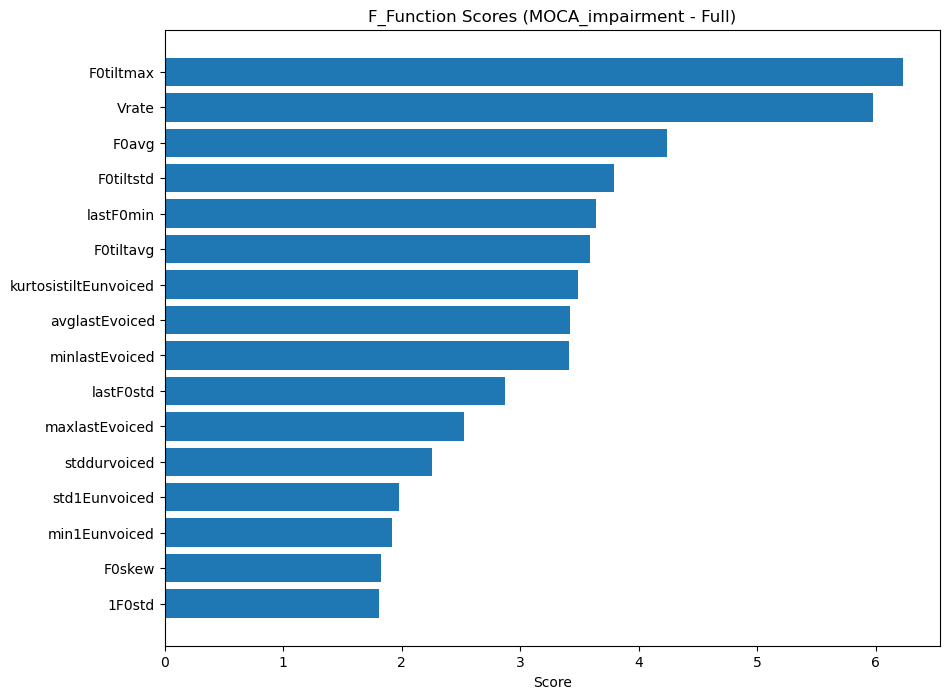

['F0tiltmax', 'Vrate', 'F0avg', 'F0tiltstd', 'lastF0min', 'F0tiltavg', 'kurtosistiltEunvoiced', 'avglastEvoiced', 'minlastEvoiced', 'lastF0std', 'maxlastEvoiced', 'stddurvoiced', 'std1Eunvoiced', 'min1Eunvoiced', 'F0skew', '1F0std']


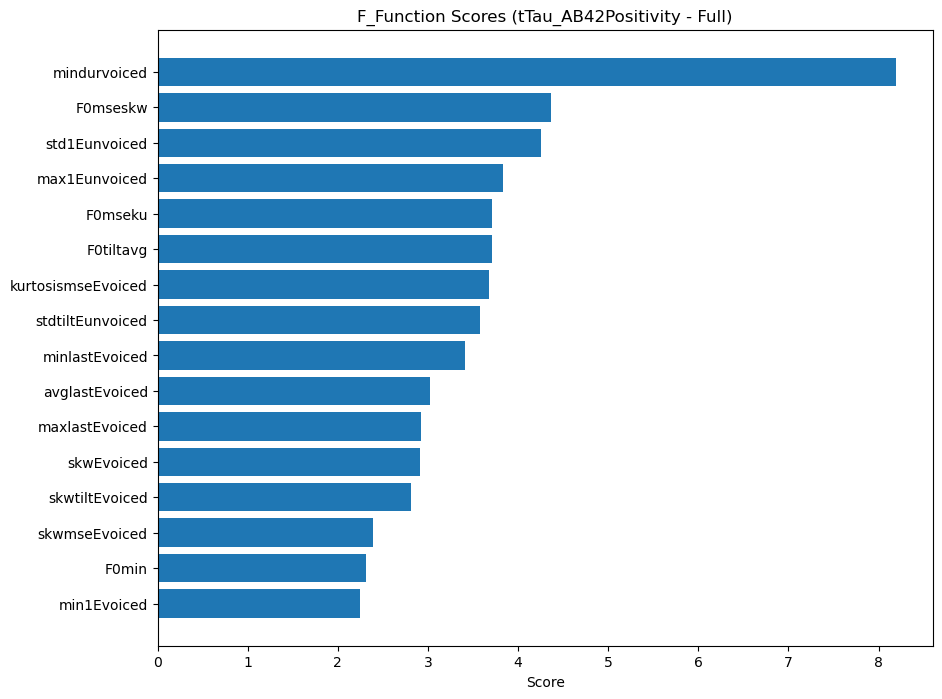

['mindurvoiced', 'F0mseskw', 'std1Eunvoiced', 'max1Eunvoiced', 'F0mseku', 'F0tiltavg', 'kurtosismseEvoiced', 'stdtiltEunvoiced', 'minlastEvoiced', 'avglastEvoiced', 'maxlastEvoiced', 'skwEvoiced', 'skwtiltEvoiced', 'skwmseEvoiced', 'F0min', 'min1Evoiced']


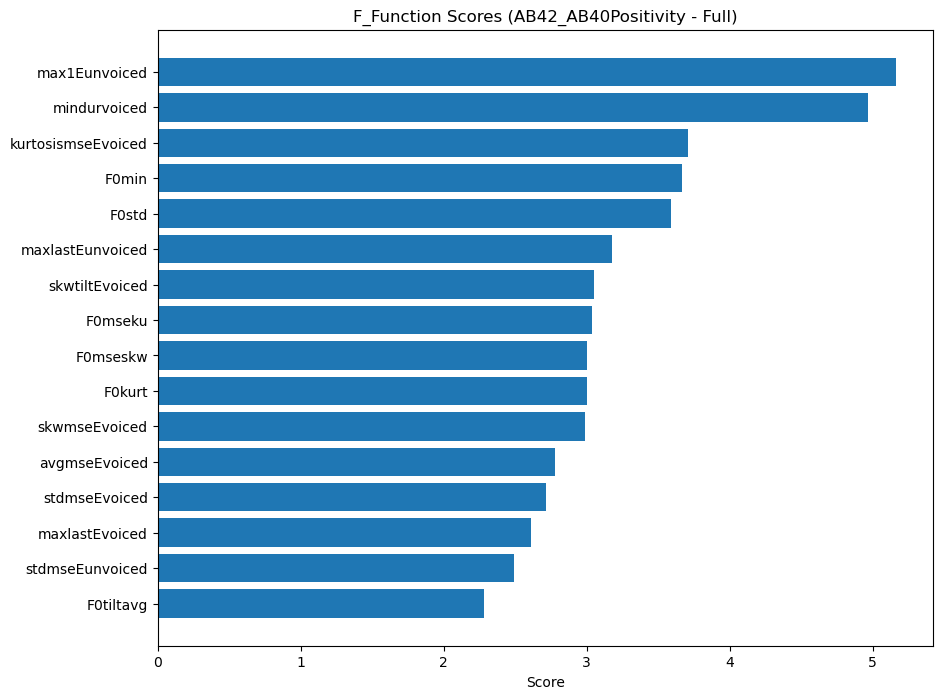

['max1Eunvoiced', 'mindurvoiced', 'kurtosismseEvoiced', 'F0min', 'F0std', 'maxlastEunvoiced', 'skwtiltEvoiced', 'F0mseku', 'F0mseskw', 'F0kurt', 'skwmseEvoiced', 'avgmseEvoiced', 'stdmseEvoiced', 'maxlastEvoiced', 'stdmseEunvoiced', 'F0tiltavg']


In [11]:
f_info('MOCA_impairment')
f_info('tTau_AB42Positivity')
f_info('AB42_AB40Positivity')

### No Audio

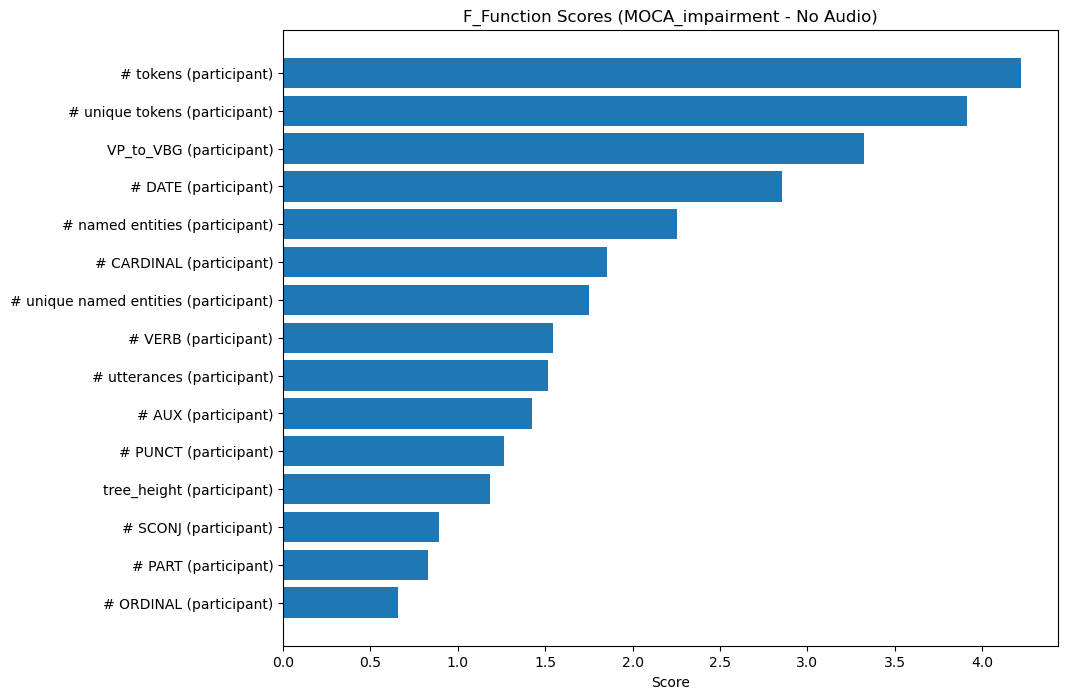

['# tokens (participant)', '# unique tokens (participant)', 'VP_to_VBG (participant)', '# DATE (participant)', '# named entities (participant)', '# CARDINAL (participant)', '# unique named entities (participant)', '# VERB (participant)', '# utterances (participant)', '# AUX (participant)', '# PUNCT (participant)', 'tree_height (participant)', '# SCONJ (participant)', '# PART (participant)', '# ORDINAL (participant)']


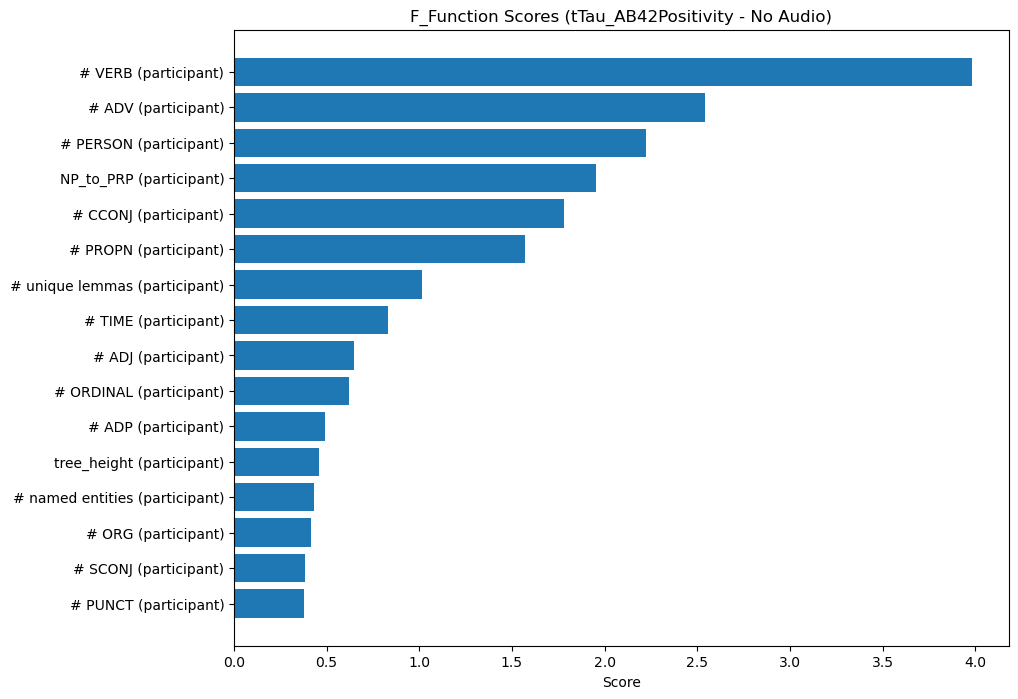

['# VERB (participant)', '# ADV (participant)', '# PERSON (participant)', 'NP_to_PRP (participant)', '# CCONJ (participant)', '# PROPN (participant)', '# unique lemmas (participant)', '# TIME (participant)', '# ADJ (participant)', '# ORDINAL (participant)', '# ADP (participant)', 'tree_height (participant)', '# named entities (participant)', '# ORG (participant)', '# SCONJ (participant)', '# PUNCT (participant)']


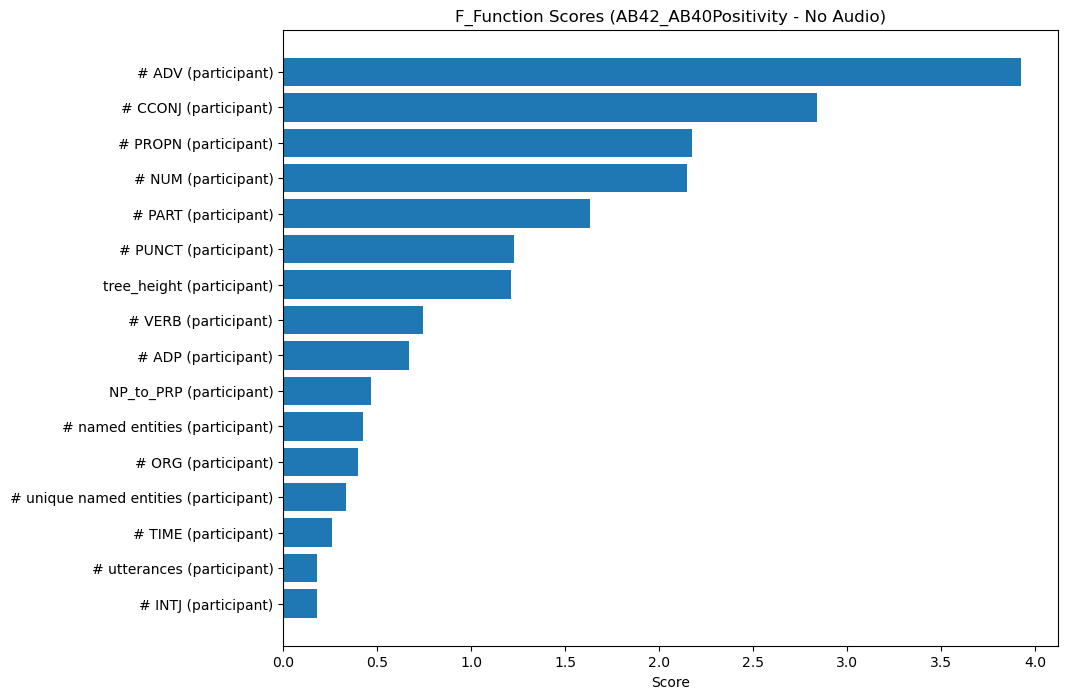

['# ADV (participant)', '# CCONJ (participant)', '# PROPN (participant)', '# NUM (participant)', '# PART (participant)', '# PUNCT (participant)', 'tree_height (participant)', '# VERB (participant)', '# ADP (participant)', 'NP_to_PRP (participant)', '# named entities (participant)', '# ORG (participant)', '# unique named entities (participant)', '# TIME (participant)', '# utterances (participant)', '# INTJ (participant)']


In [12]:
f_info('MOCA_impairment', audio=False)
f_info('tTau_AB42Positivity', audio=False)
f_info('AB42_AB40Positivity', audio=False)

## Mutual Information

In [13]:
def m_info(to_predict, audio=True):
    PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME if audio else NO_AUDIO_DATASET_NAME)
    # Load the dataset
    X_raw, y_raw = load_raw_data(PATH, to_predict)
    # Get the column names (without the label)
    cols = X_raw.columns.to_list()
    X, y = X_raw.to_numpy(), y_raw.to_numpy().ravel()

    importances = mutual_info_classif(X, y)
    feat_importances = pd.Series(importances, cols)
    feat_importances = feat_importances.nlargest(30).sort_values()
    feat_importances.plot(kind='barh')
    plt.title(f'Mutual Information ({to_predict} - {"Full" if audio else "No Audio"})')
    plt.show()
    print(list(feat_importances.index))
    print()

### Full Data

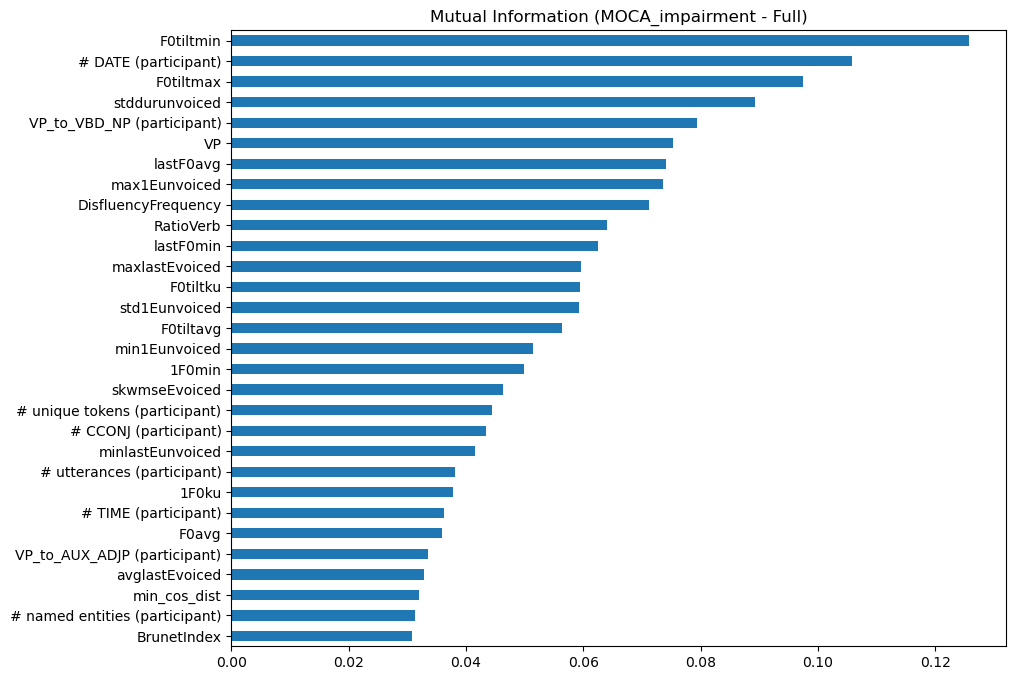

['BrunetIndex', '# named entities (participant)', 'min_cos_dist', 'avglastEvoiced', 'VP_to_AUX_ADJP (participant)', 'F0avg', '# TIME (participant)', '1F0ku', '# utterances (participant)', 'minlastEunvoiced', '# CCONJ (participant)', '# unique tokens (participant)', 'skwmseEvoiced', '1F0min', 'min1Eunvoiced', 'F0tiltavg', 'std1Eunvoiced', 'F0tiltku', 'maxlastEvoiced', 'lastF0min', 'RatioVerb', 'DisfluencyFrequency', 'max1Eunvoiced', 'lastF0avg', 'VP', 'VP_to_VBD_NP (participant)', 'stddurunvoiced', 'F0tiltmax', '# DATE (participant)', 'F0tiltmin']



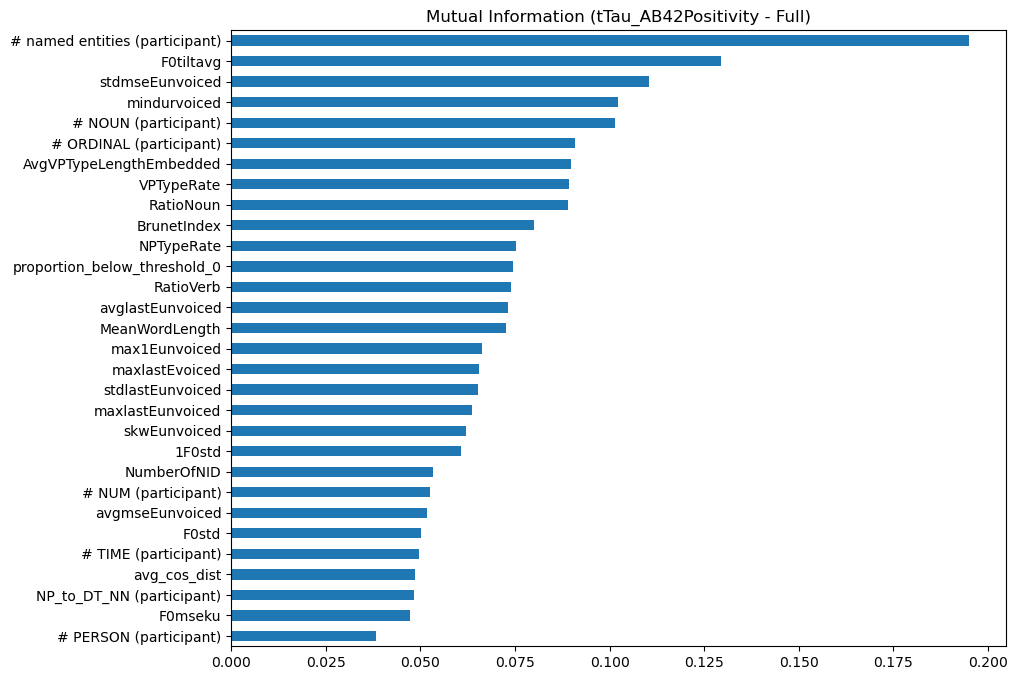

['# PERSON (participant)', 'F0mseku', 'NP_to_DT_NN (participant)', 'avg_cos_dist', '# TIME (participant)', 'F0std', 'avgmseEunvoiced', '# NUM (participant)', 'NumberOfNID', '1F0std', 'skwEunvoiced', 'maxlastEunvoiced', 'stdlastEunvoiced', 'maxlastEvoiced', 'max1Eunvoiced', 'MeanWordLength', 'avglastEunvoiced', 'RatioVerb', 'proportion_below_threshold_0', 'NPTypeRate', 'BrunetIndex', 'RatioNoun', 'VPTypeRate', 'AvgVPTypeLengthEmbedded', '# ORDINAL (participant)', '# NOUN (participant)', 'mindurvoiced', 'stdmseEunvoiced', 'F0tiltavg', '# named entities (participant)']



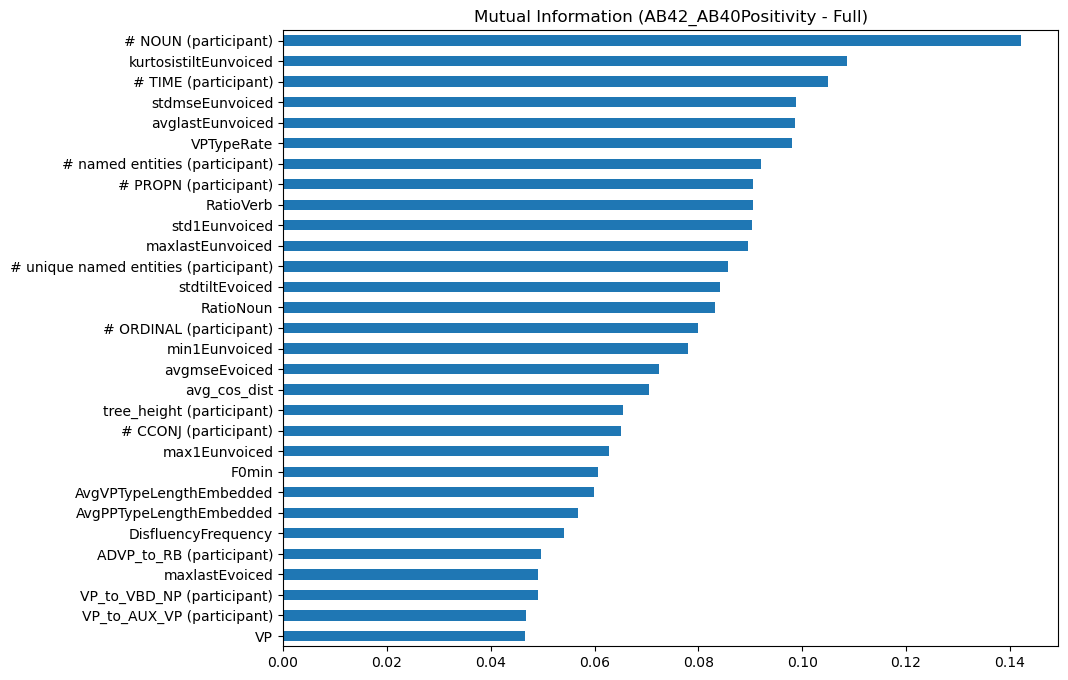

['VP', 'VP_to_AUX_VP (participant)', 'VP_to_VBD_NP (participant)', 'maxlastEvoiced', 'ADVP_to_RB (participant)', 'DisfluencyFrequency', 'AvgPPTypeLengthEmbedded', 'AvgVPTypeLengthEmbedded', 'F0min', 'max1Eunvoiced', '# CCONJ (participant)', 'tree_height (participant)', 'avg_cos_dist', 'avgmseEvoiced', 'min1Eunvoiced', '# ORDINAL (participant)', 'RatioNoun', 'stdtiltEvoiced', '# unique named entities (participant)', 'maxlastEunvoiced', 'std1Eunvoiced', 'RatioVerb', '# PROPN (participant)', '# named entities (participant)', 'VPTypeRate', 'avglastEunvoiced', 'stdmseEunvoiced', '# TIME (participant)', 'kurtosistiltEunvoiced', '# NOUN (participant)']



In [14]:
m_info('MOCA_impairment')
m_info('tTau_AB42Positivity')
m_info('AB42_AB40Positivity')

### No Audio

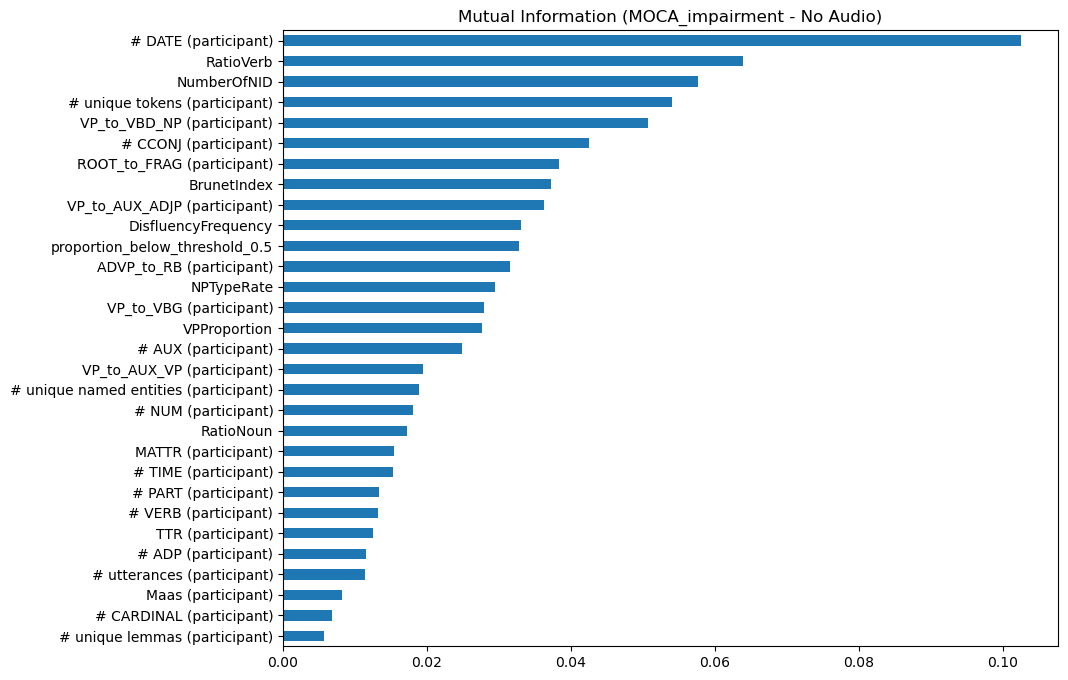

['# unique lemmas (participant)', '# CARDINAL (participant)', 'Maas (participant)', '# utterances (participant)', '# ADP (participant)', 'TTR (participant)', '# VERB (participant)', '# PART (participant)', '# TIME (participant)', 'MATTR (participant)', 'RatioNoun', '# NUM (participant)', '# unique named entities (participant)', 'VP_to_AUX_VP (participant)', '# AUX (participant)', 'VPProportion', 'VP_to_VBG (participant)', 'NPTypeRate', 'ADVP_to_RB (participant)', 'proportion_below_threshold_0.5', 'DisfluencyFrequency', 'VP_to_AUX_ADJP (participant)', 'BrunetIndex', 'ROOT_to_FRAG (participant)', '# CCONJ (participant)', 'VP_to_VBD_NP (participant)', '# unique tokens (participant)', 'NumberOfNID', 'RatioVerb', '# DATE (participant)']



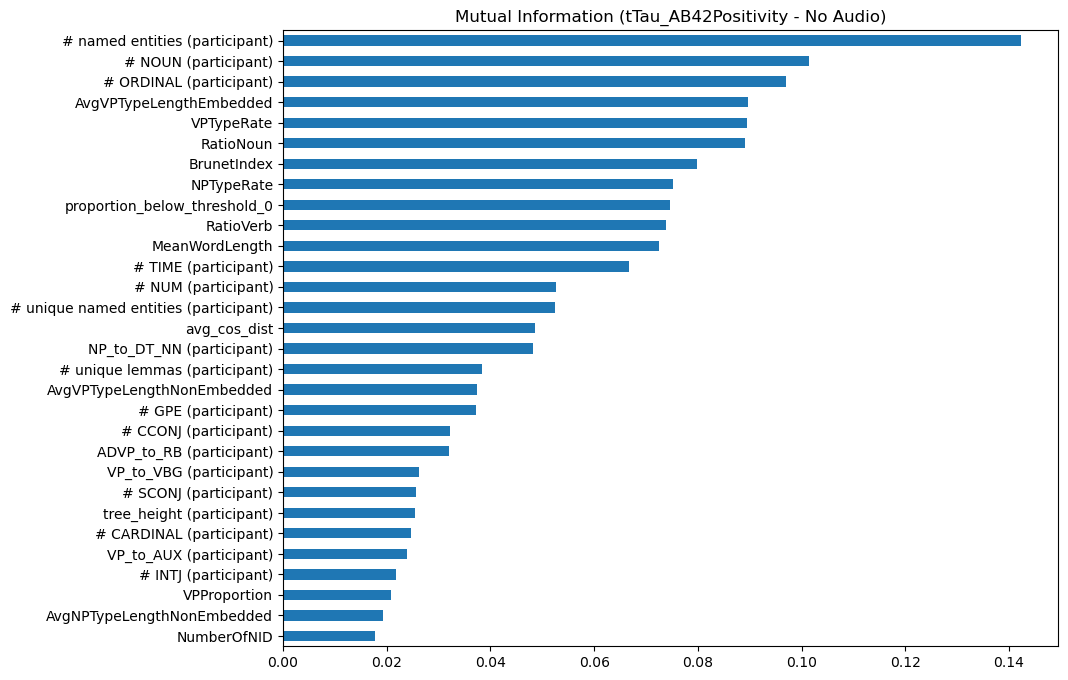

['NumberOfNID', 'AvgNPTypeLengthNonEmbedded', 'VPProportion', '# INTJ (participant)', 'VP_to_AUX (participant)', '# CARDINAL (participant)', 'tree_height (participant)', '# SCONJ (participant)', 'VP_to_VBG (participant)', 'ADVP_to_RB (participant)', '# CCONJ (participant)', '# GPE (participant)', 'AvgVPTypeLengthNonEmbedded', '# unique lemmas (participant)', 'NP_to_DT_NN (participant)', 'avg_cos_dist', '# unique named entities (participant)', '# NUM (participant)', '# TIME (participant)', 'MeanWordLength', 'RatioVerb', 'proportion_below_threshold_0', 'NPTypeRate', 'BrunetIndex', 'RatioNoun', 'VPTypeRate', 'AvgVPTypeLengthEmbedded', '# ORDINAL (participant)', '# NOUN (participant)', '# named entities (participant)']



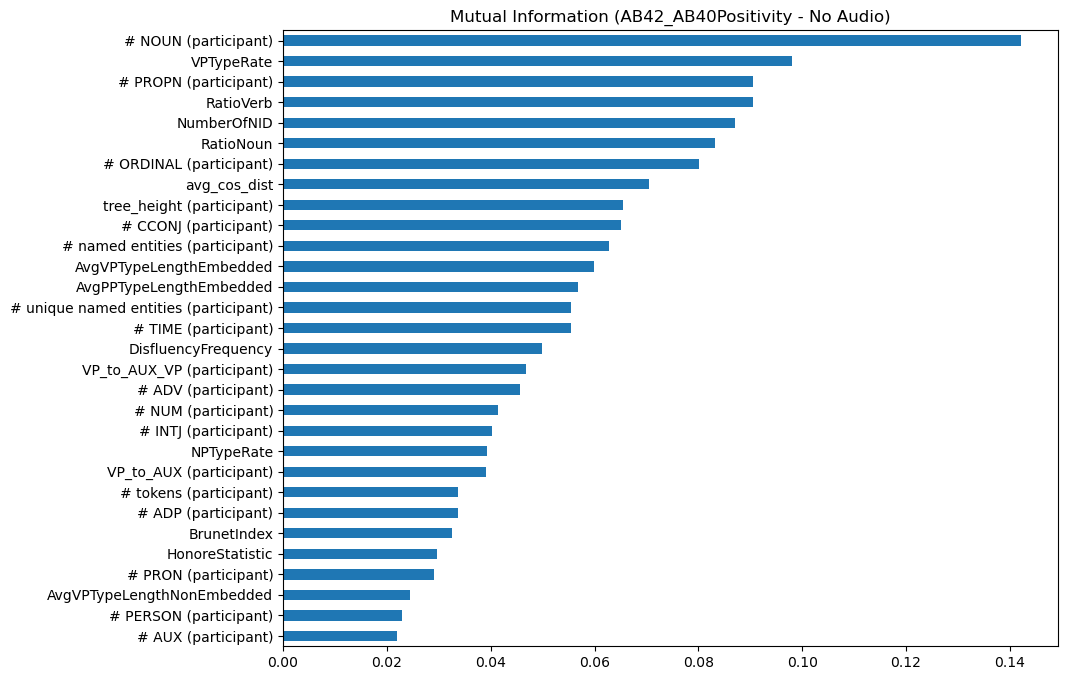

['# AUX (participant)', '# PERSON (participant)', 'AvgVPTypeLengthNonEmbedded', '# PRON (participant)', 'HonoreStatistic', 'BrunetIndex', '# ADP (participant)', '# tokens (participant)', 'VP_to_AUX (participant)', 'NPTypeRate', '# INTJ (participant)', '# NUM (participant)', '# ADV (participant)', 'VP_to_AUX_VP (participant)', 'DisfluencyFrequency', '# TIME (participant)', '# unique named entities (participant)', 'AvgPPTypeLengthEmbedded', 'AvgVPTypeLengthEmbedded', '# named entities (participant)', '# CCONJ (participant)', 'tree_height (participant)', 'avg_cos_dist', '# ORDINAL (participant)', 'RatioNoun', 'NumberOfNID', 'RatioVerb', '# PROPN (participant)', 'VPTypeRate', '# NOUN (participant)']



In [15]:
m_info('MOCA_impairment', audio=False)
m_info('tTau_AB42Positivity', audio=False)
m_info('AB42_AB40Positivity', audio=False)

# Forward Selection Approach

In [151]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier

def forward(to_predict, dataset='full.csv'):
    # Load the dataset
    X_raw, y_raw = load_raw_data(os.path.join(DATA_FOLDER, dataset), to_predict)
    # Get the column names (without the label)
    cols = X_raw.columns
    X, y = X_raw.to_numpy(), y_raw.to_numpy().ravel()
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2)
    X_train, y_train = SMOTE.fit_resample(X_train, y_train)

    ffs = SequentialFeatureSelector(
        RandomForestClassifier(),
        k_features=10,
        forward=True,
        n_jobs=-1
     )

    ffs.fit(X_train, y_train)

    out = ''
    out += (str(to_predict) + '\n')
    out += f'Best scores: {ffs.k_score_}\n'
    out += (str(ffs.k_feature_names_) + '\n')
    out += (str(cols[list(ffs.k_feature_idx_)]) + '\n')
    out += ('*'*60 + '\n')

    return out, ffs

## No Audio

In [152]:
X_raw, y_raw = load_raw_data(os.path.join(DATA_FOLDER, 'no_audio.csv'), 'tTau_AB42Positivity')
NO_AUDIO_COLS = X_raw.columns

### MOCA_impairment

In [153]:
moca_res_no_audio = []
for _ in tqdm(range(100)):
    moca_res_no_audio.append(forward('MOCA_impairment', dataset='no_audio.csv'))

100%|██████████| 100/100 [1:12:41<00:00, 43.61s/it]


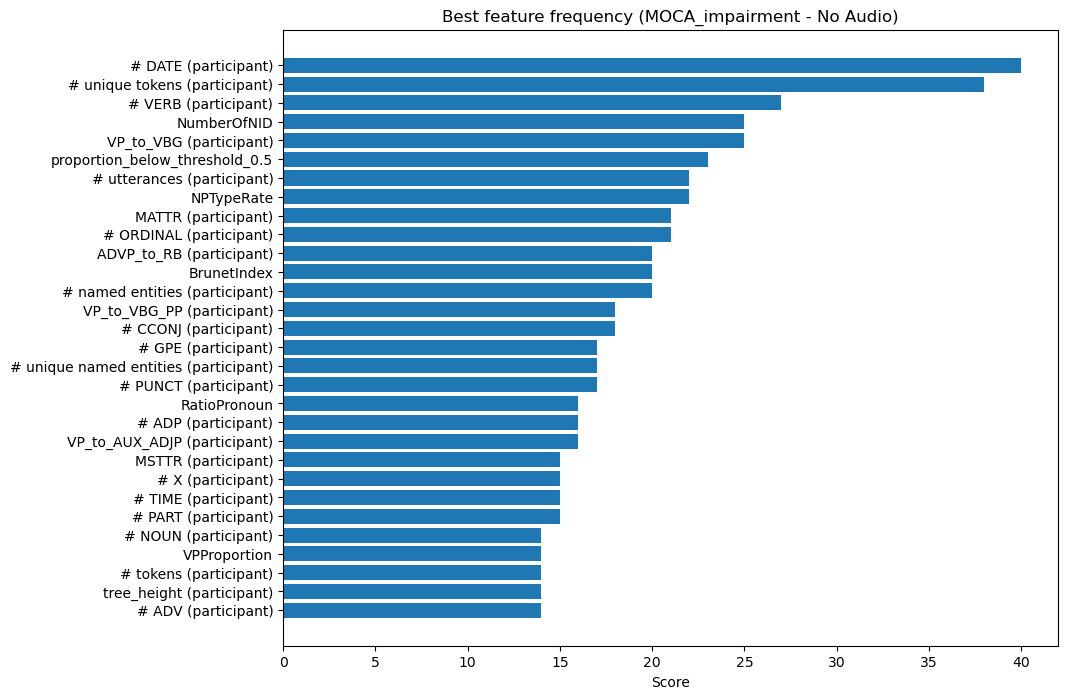

['# DATE (participant)', '# unique tokens (participant)', '# VERB (participant)', 'NumberOfNID', 'VP_to_VBG (participant)', 'proportion_below_threshold_0.5', '# utterances (participant)', 'NPTypeRate', 'MATTR (participant)', '# ORDINAL (participant)', 'ADVP_to_RB (participant)', 'BrunetIndex', '# named entities (participant)', 'VP_to_VBG_PP (participant)', '# CCONJ (participant)', '# GPE (participant)', '# unique named entities (participant)', '# PUNCT (participant)', 'RatioPronoun', '# ADP (participant)', 'VP_to_AUX_ADJP (participant)', 'MSTTR (participant)', '# X (participant)', '# TIME (participant)', '# PART (participant)', '# NOUN (participant)', 'VPProportion', '# tokens (participant)', 'tree_height (participant)', '# ADV (participant)']


In [330]:
count = {}
for _, ffs in moca_res_no_audio:
    for feat in list(ffs.k_feature_names_):
        if feat not in count:
            count[feat] = 0
        count[feat] += 1

moca_feats_no_audio, moca_freqs_no_audio = zip(*sorted(list(count.items()), key=(lambda x: x[1])))
moca_feats_no_audio = list(NO_AUDIO_COLS[list(map(int, moca_feats_no_audio))])
moca_final_feats_no_audio = list(reversed(moca_feats_no_audio[-30:]))
moca_final_freqs_no_audio = list(reversed(moca_freqs_no_audio[-30:]))
plot_best_feat(moca_final_feats_no_audio, moca_final_freqs_no_audio, title='Best feature frequency (MOCA_impairment - No Audio)')

In [ ]:
__feats = list(reversed(['avg_cos_dist', '# SCONJ (participant)', '# ORG (participant)', '# ADP (participant)', '# DET (participant)', 'MeanWordLength', '# PRON (participant)', '# PROPN (participant)', 'NPTypeRate', '# ADV (participant)', 'proportion_below_threshold_0.5', 'PProportion', 'BrunetIndex', '# unique named entities (participant)', '# X (participant)', 'MATTR (participant)', 'ROOT_to_FRAG (participant)', 'RatioNoun', '# unique lemmas (participant)', 'VPTypeRate', 'RatioVerb', '# TIME (participant)', '# ORDINAL (participant)', '# NOUN (participant)', 'AvgVPTypeLengthEmbedded', 'min_cos_dist', 'NumberOfNID', 'VP_to_VBG_PP (participant)', 'VP_to_VBD_NP (participant)', 'ADVP_to_RB (participant)']))
__freqs = list(reversed([11,11,11,11,12,12,12,12,13,14,14,14,15,16,16,17,18,21,22,25,30,33,34,34,37,47,54,55,55,61]))
plot_best_feat(__feats, __freqs, title='Best feature frequency (AB42_AB40Positivity - No Audio)')

### tTau_AB42Positivity

In [ ]:
tTau_res_no_audio = []
for _ in tqdm(range(100)):
    tTau_res_no_audio.append(forward('tTau_AB42Positivity', dataset='no_audio.csv'))

100%|██████████| 100/100 [1:08:31<00:00, 41.12s/it]


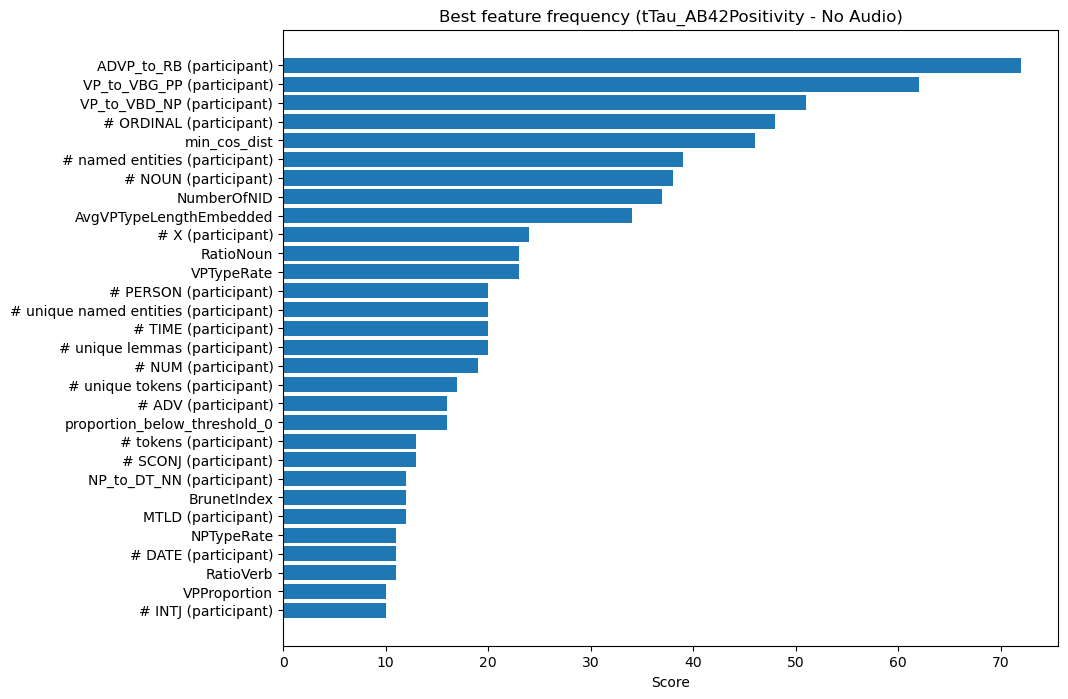

['ADVP_to_RB (participant)', 'VP_to_VBG_PP (participant)', 'VP_to_VBD_NP (participant)', '# ORDINAL (participant)', 'min_cos_dist', '# named entities (participant)', '# NOUN (participant)', 'NumberOfNID', 'AvgVPTypeLengthEmbedded', '# X (participant)', 'RatioNoun', 'VPTypeRate', '# PERSON (participant)', '# unique named entities (participant)', '# TIME (participant)', '# unique lemmas (participant)', '# NUM (participant)', '# unique tokens (participant)', '# ADV (participant)', 'proportion_below_threshold_0', '# tokens (participant)', '# SCONJ (participant)', 'NP_to_DT_NN (participant)', 'BrunetIndex', 'MTLD (participant)', 'NPTypeRate', '# DATE (participant)', 'RatioVerb', 'VPProportion', '# INTJ (participant)']


In [326]:
count = {}
for _, ffs in tTau_res_no_audio:
    for feat in list(ffs.k_feature_names_):
        if feat not in count:
            count[feat] = 0
        count[feat] += 1

tTau_feats_no_audio, tTau_freqs_no_audio = zip(*sorted(list(count.items()), key=(lambda x: x[1])))
tTau_feats_no_audio = list(NO_AUDIO_COLS[list(map(int, tTau_feats_no_audio))])
tTau_final_feats_no_audio = list(reversed(tTau_feats_no_audio[-30:]))
tTau_final_freqs_no_audio = list(reversed(tTau_freqs_no_audio[-30:]))
plot_best_feat(tTau_final_feats_no_audio, tTau_final_freqs_no_audio, title='Best feature frequency (tTau_AB42Positivity - No Audio)')

### AB42_AB40Positivity

In [ ]:
ab42_res_no_audio = []
for _ in tqdm(range(100)):
    ab42_res_no_audio.append(forward('AB42_AB40Positivity', dataset='no_audio.csv'))

100%|██████████| 100/100 [1:08:15<00:00, 40.96s/it]


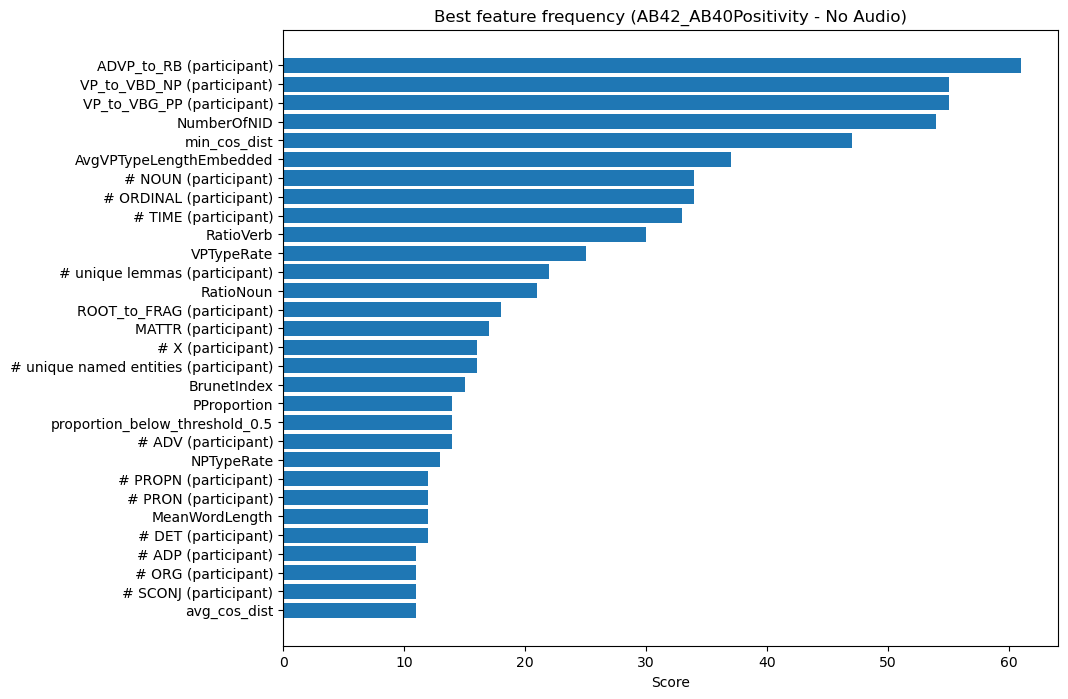

['ADVP_to_RB (participant)', 'VP_to_VBD_NP (participant)', 'VP_to_VBG_PP (participant)', 'NumberOfNID', 'min_cos_dist', 'AvgVPTypeLengthEmbedded', '# NOUN (participant)', '# ORDINAL (participant)', '# TIME (participant)', 'RatioVerb', 'VPTypeRate', '# unique lemmas (participant)', 'RatioNoun', 'ROOT_to_FRAG (participant)', 'MATTR (participant)', '# X (participant)', '# unique named entities (participant)', 'BrunetIndex', 'PProportion', 'proportion_below_threshold_0.5', '# ADV (participant)', 'NPTypeRate', '# PROPN (participant)', '# PRON (participant)', 'MeanWordLength', '# DET (participant)', '# ADP (participant)', '# ORG (participant)', '# SCONJ (participant)', 'avg_cos_dist']


In [328]:
count = {}
for _, ffs in ab42_res_no_audio:
    for feat in list(ffs.k_feature_names_):
        if feat not in count:
            count[feat] = 0
        count[feat] += 1

ab42_feats_no_audio, ab42_freqs_no_audio = zip(*sorted(list(count.items()), key=(lambda x: x[1])))
ab42_feats_no_audio = list(NO_AUDIO_COLS[list(map(int, ab42_feats_no_audio))])
ab42_final_feats_no_audio = list(reversed(ab42_feats_no_audio[-30:]))
ab42_final_freqs_no_audio = list(reversed(ab42_freqs_no_audio[-30:]))
plot_best_feat(ab42_final_feats_no_audio, ab42_final_freqs_no_audio, title='Best feature frequenzy (AB42_AB40Positivity - No Audio)')

# Best features combination

After some analysis, it's clear that the best (and more easily explainable) approach is based on using the No Audio data.</br>
Thus, we will try to understand which combnation of the previously highlighted features works best for each target label.

In [145]:
PATH = os.path.join(DATA_FOLDER, NO_AUDIO_DATASET_NAME)
STEPS = [2, 4, 8, 16]

def check_top_features(X, y, feats, steps=STEPS):
    len_feats = len(feats)
    mean_accs, mean_f1s = [], []
    stdev_accs, stdev_f1s = [], []
    for _step in steps:
        step = min(_step, len_feats)
        print(f'\nChecking top {step} features')
        
        X_current = X[feats[:step]]
        accs, f1s = [], []
        for _ in tqdm(range(1000)):
            X_train, X_test, y_train, y_test = train_test_split(X_current, y, test_size=0.2, stratify=y)
            X_train, y_train = SMOTE.fit_resample(X_train, y_train)

            model = RandomForestClassifier(n_estimators=200)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            accs.append(accuracy_score(y_test, y_pred))
            f1s.append(f1_score(y_test, y_pred))

        mean_accs.append(np.mean(accs)), mean_f1s.append(np.mean(f1s))
        stdev_accs.append(np.std(accs)), stdev_f1s.append(np.std(f1s))

        if step != _step:
            break

    return (mean_accs, stdev_accs), (mean_f1s, stdev_f1s)


In [149]:
def plot_acc_and_f1(accs, f1s, feats, title, _steps=STEPS, verbose=False):
    steps = _steps[:]
    if len(feats) < _steps[-1]:
        steps = _steps[:len(accs[0])]
        steps[-1] = min(steps[-1], len(feats))
    
    x_axis = list(range(len(steps)))[:len(accs[0])]
    plt.figure(figsize=(14,6))
    plt.title(title)
    plt.subplot(121)
    plt.title('Average Accuracy')
    plt.plot(x_axis, accs[0], marker='o')
    plt.xticks(ticks=x_axis, labels=steps)
    plt.subplot(122)
    plt.title('Average F1 Score')
    plt.plot(x_axis, f1s[0], marker='o')
    plt.xticks(ticks=x_axis, labels=steps)
    plt.show()

    if verbose:
        for idx, step in enumerate(steps):
            print(f'**********   Top {step}   **********')
            print(f'Accuracy: {accs[0][idx]} +- {accs[1][idx]}')
            print(f'F1 Score: {f1s[0][idx]} +- {f1s[1][idx]}\n')

In [57]:
# Data Loading

X_moca, y_moca = load_raw_data(PATH, 'MOCA_impairment')
X_ttau, y_ttau = load_raw_data(PATH, 'tTau_AB42Positivity')
X_ab42, y_ab42 = load_raw_data(PATH, 'AB42_AB40Positivity')

### MOCA_impairment

#### ML Approach


Checking top 2 features


100%|██████████| 1000/1000 [03:33<00:00,  4.69it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:42<00:00,  4.50it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:37<00:00,  4.60it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:56<00:00,  3.37it/s]


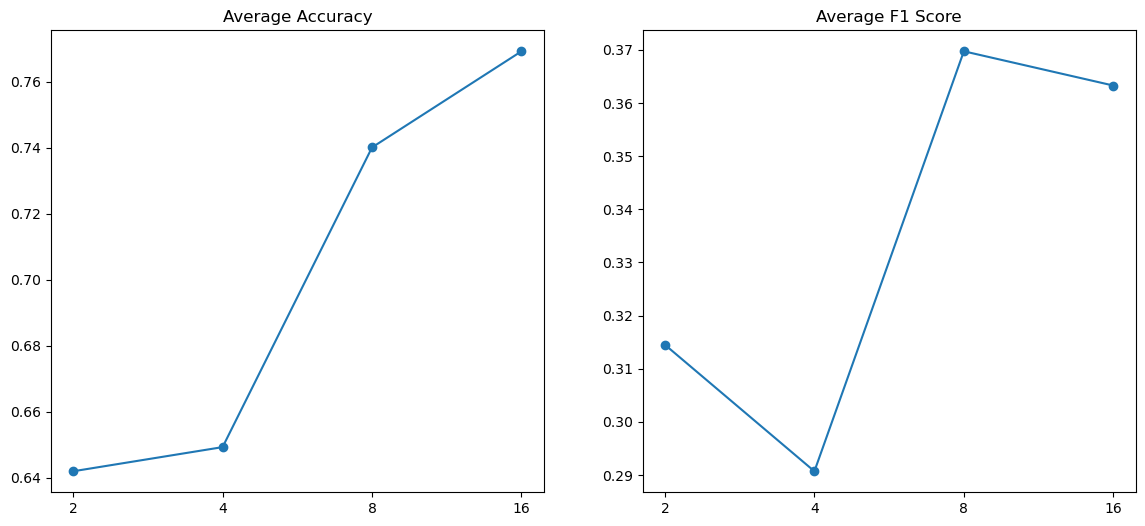

In [58]:
moca_ml_feats = [
    '# unique tokens (participant)', '# tokens (participant)', '# unique lemmas (participant)', 
    'NPTypeRate', '# utterances (participant)', '# DATE (participant)', 'TTR (participant)',
    'VP_to_AUX_ADJP (participant)', 'VP_to_VBG (participant)', 'MATTR (participant)',
    '# VERB (participant)', 'RatioPronoun', '# PUNCT (participant)', '# named entities (participant)',
    'NP_to_DT_NN (participant)', 'tree_height (participant)', 'HonoreStatistic', 'BrunetIndex',
    '# AUX (participant)', '# DET (participant)', 'avg_cos_dist', 'MSTTR (participant)',
    'MTLD (participant)', 'AvgVPTypeLengthNonEmbedded', 'proportion_below_threshold_0',
    '# GPE (participant)', 'VPProportion', '# unique named entities (participant)',
    'VPTypeRate', '# CARDINAL (participant)'
]

moca_ml_accs, moca_ml_f1s = check_top_features(X_moca, y_moca, moca_ml_feats)
plot_acc_and_f1(moca_ml_accs, moca_ml_f1s, moca_ml_feats, 'MOCA_impairment (ML Approach)')

#### Statistical Approach (F_Classif)


Checking top 2 features


100%|██████████| 1000/1000 [03:26<00:00,  4.85it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:34<00:00,  4.66it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:35<00:00,  4.64it/s]



Checking top 15 features


100%|██████████| 1000/1000 [03:44<00:00,  4.46it/s]


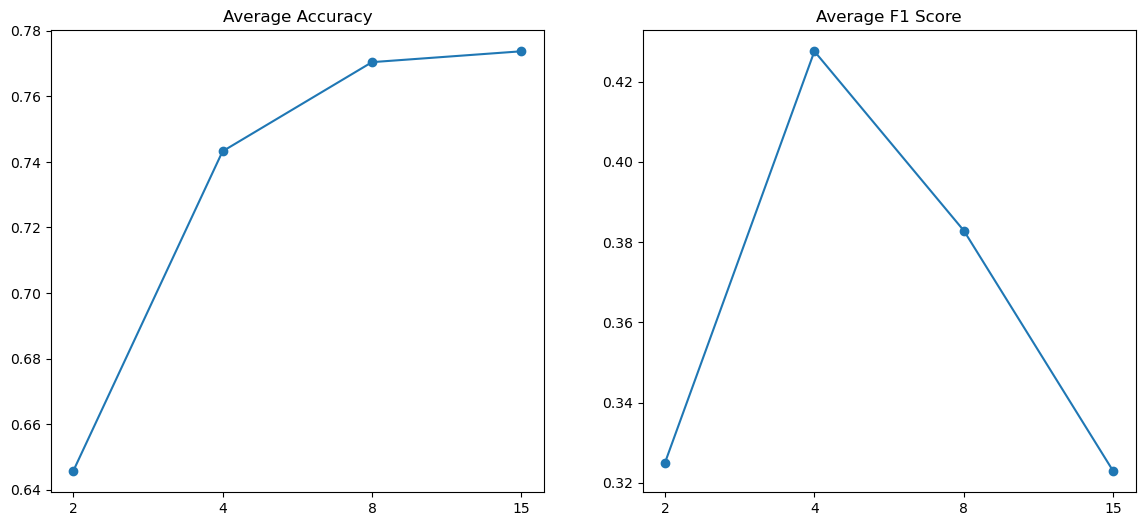

In [59]:
moca_f_classif_feats = [
    '# tokens (participant)', '# unique tokens (participant)', 'VP_to_VBG (participant)', 
    '# DATE (participant)', '# named entities (participant)', '# CARDINAL (participant)',
    '# unique named entities (participant)', '# VERB (participant)', '# utterances (participant)',
    '# AUX (participant)', '# PUNCT (participant)', 'tree_height (participant)',
    '# SCONJ (participant)', '# PART (participant)', '# ORDINAL (participant)'
]

moca_f_classif_accs, moca_f_classif_f1s = check_top_features(X_moca, y_moca, moca_f_classif_feats)
plot_acc_and_f1(moca_f_classif_accs, moca_f_classif_f1s, moca_f_classif_feats, 'MOCA_impairment (Stat Approach - F_Classif)')

#### Statistical Approach (Mutual Information)


Checking top 2 features


100%|██████████| 1000/1000 [03:27<00:00,  4.82it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:31<00:00,  4.73it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:32<00:00,  4.71it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:56<00:00,  3.38it/s]


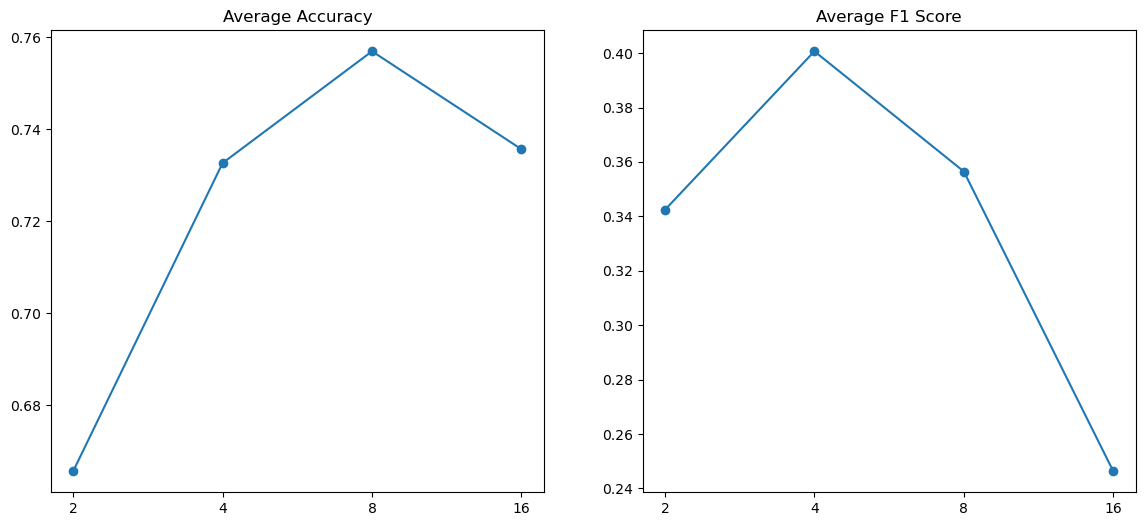

In [60]:
moca_mutual_info_feats = [
    '# DATE (participant)', 'RatioVerb', 'NumberOfNID', '# unique tokens (participant)',
    'VP_to_VBD_NP (participant)', '# CCONJ (participant)', 'ROOT_to_FRAG (participant)', 'BrunetIndex',
    'VP_to_AUX_ADJP (participant)', 'DisfluencyFrequency', 'proportion_below_threshold_0.5', 'ADVP_to_RB (participant)',
    'NPTypeRate', 'VP_to_VBG (participant)', 'VPProportion', '# AUX (participant)',
    'VP_to_AUX_VP (participant)', '# unique named entities (participant)', '# NUM (participant)', 'RatioNoun',
    'MATTR (participant)', '# TIME (participant)', '# PART (participant)', '# VERB (participant)',
    'TTR (participant)', '# ADP (participant)', '# utterances (participant)', 'Maas (participant)',
    '# CARDINAL (participant)', '# unique lemmas (participant)'
]

moca_mutual_info_accs, moca_mutual_info_f1s = check_top_features(X_moca, y_moca, moca_mutual_info_feats)
plot_acc_and_f1(moca_mutual_info_accs, moca_mutual_info_f1s, moca_mutual_info_feats, 'MOCA_impairment (Stat Approach - Mutual Information)')

#### Forward Selection Approach


Checking top 2 features


100%|██████████| 1000/1000 [03:11<00:00,  5.23it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:13<00:00,  5.17it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:27<00:00,  4.83it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


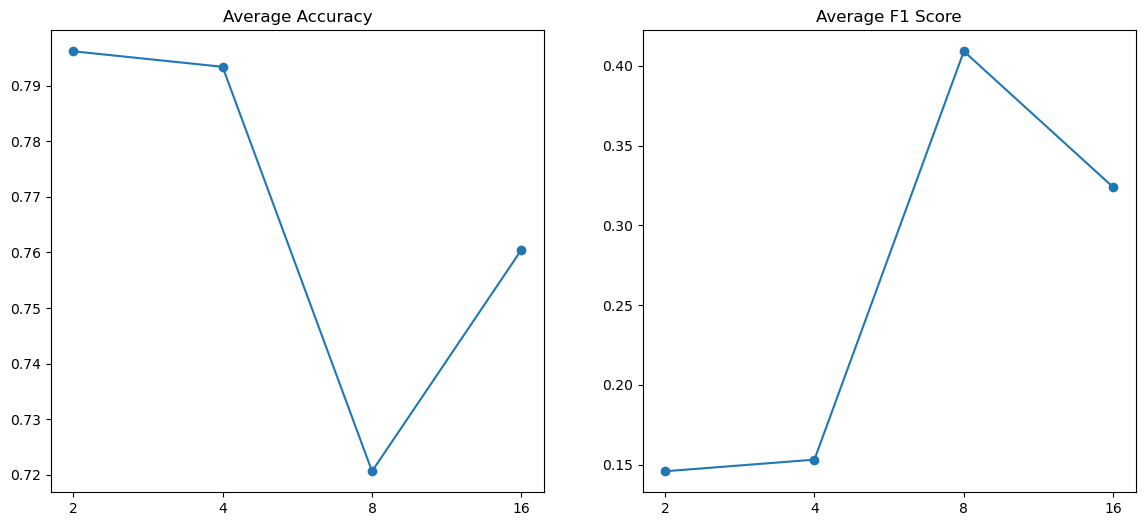

In [61]:
moca_fs_feats = [
    '# DATE (participant)', '# unique tokens (participant)', '# VERB (participant)', 'NumberOfNID', 'VP_to_VBG (participant)',
    'proportion_below_threshold_0.5', '# utterances (participant)', 'NPTypeRate', 'MATTR (participant)', '# ORDINAL (participant)',
    'ADVP_to_RB (participant)', 'BrunetIndex', '# named entities (participant)', 'VP_to_VBG_PP (participant)', '# CCONJ (participant)',
    '# GPE (participant)', '# unique named entities (participant)', '# PUNCT (participant)', 'RatioPronoun', '# ADP (participant)',
    'VP_to_AUX_ADJP (participant)', 'MSTTR (participant)', '# X (participant)', '# TIME (participant)', '# PART (participant)',
    '# NOUN (participant)', 'VPProportion', '# tokens (participant)', 'tree_height (participant)', '# ADV (participant)'
]


moca_fs_accs, moca_fs_f1s = check_top_features(X_moca, y_moca, moca_fs_feats)
plot_acc_and_f1(moca_fs_accs, moca_fs_f1s, moca_fs_feats, 'MOCA_impairment (Forward Selection Approach)')

#### Mixed Sets

In [170]:
moca_top_features = []
a, b = moca_ml_feats[:16], moca_f_classif_feats[:8]
for idx in range(max(len(a), len(b))):
    if idx < len(a):
        if a[idx] not in moca_top_features:
            moca_top_features.append(a[idx])
    if idx < len(b):
        if b[idx] not in moca_top_features:
            moca_top_features.append(b[idx])

moca_top_accs, moca_top_f1s = check_top_features(X_moca, y_moca, moca_top_features, [2,4,8,16,18])


Checking top 2 features


100%|██████████| 1000/1000 [03:32<00:00,  4.70it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:41<00:00,  4.51it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:44<00:00,  4.46it/s]



Checking top 16 features


100%|██████████| 1000/1000 [05:07<00:00,  3.26it/s]



Checking top 18 features


100%|██████████| 1000/1000 [05:02<00:00,  3.31it/s]


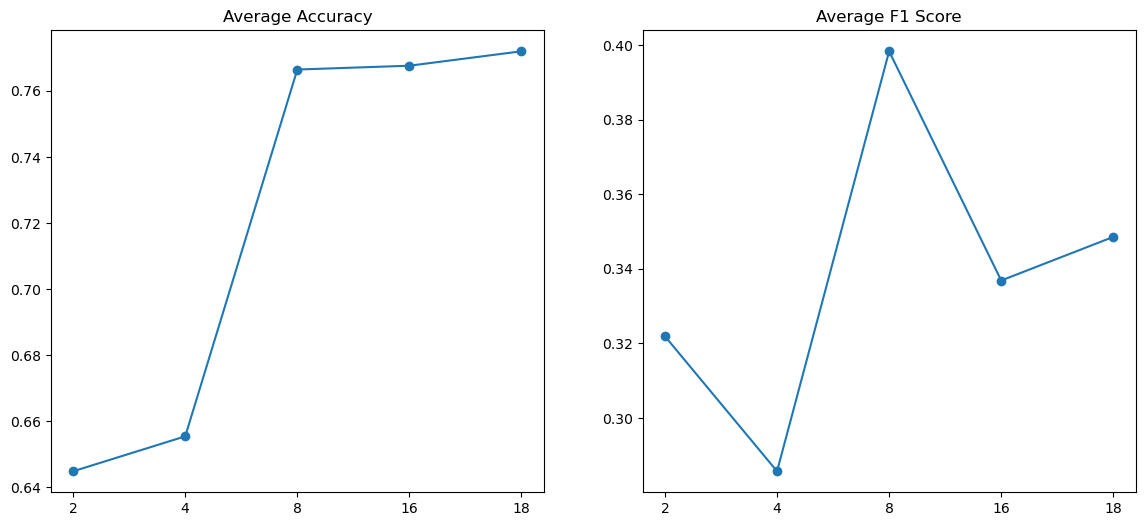

**********   Top 2   **********
Accuracy: 0.6448947368421052 +- 0.09828150816733242
F1 Score: 0.3219313803843215 +- 0.16848276136796578

**********   Top 4   **********
Accuracy: 0.6554736842105262 +- 0.09027326934311583
F1 Score: 0.28575172327672327 +- 0.17335357038572297

**********   Top 8   **********
Accuracy: 0.7664736842105262 +- 0.07841983397145649
F1 Score: 0.3983206071706071 +- 0.20737979702076223

**********   Top 16   **********
Accuracy: 0.7676315789473683 +- 0.07414844360976629
F1 Score: 0.3368839105339105 +- 0.22139352570698104

**********   Top 18   **********
Accuracy: 0.7719999999999999 +- 0.07586575108944517
F1 Score: 0.3485678654678655 +- 0.21664567185067754



In [150]:
plot_acc_and_f1(moca_top_accs, moca_top_f1s, moca_top_features, 'MOCA_impairment (Mixed Set)', [2,4,8,16,18], True)

### MOCA_impairment final results

We have found mainly two ways to obtain interesting results for the `MOCA_impairment` classification task, and both are based on a set of features that is the combination of the top 16 features obtained with the ML Approach, adn the top 8 based on the Statistical Approach (f_classif). These two sets have been combined following their respective ranking, meaning that for example in position 1 and 2 we find the first ranked feature from the ML Approach and the first ranked from the F_Classif method, while removing any repeated feature. The list of features can be seen in the next block of this notebook.

The final results are:
1. Using the `top 8 features` of the combined set we obtained an `accuracy of 0.7665 +- 0.0784` and an `F1 score of 0.3983 +- 0.2074`.
2. Using all the `18 features` of the combined set we obtained an `accuracy of 0.7719 +- 0.0758` and an `F1 score of 0.3486 +- 0.2166`.\

In the end, the `top 8 features` are to be considered the best possible results, given that the full set has an F1 score simply too low to be considered a good result.

#### Mixed Feature list

1. `# unique tokens (participant)`
2. `# tokens (participant)`
3. `# unique lemmas (participant)`
4. `VP_to_VBG (participant)`
5. `NPTypeRate`
6. `# DATE (participant)`
7. `# utterances (participant)`
8. `# named entities (participant)`
9. `# CARDINAL (participant)`
10. `TTR (participant)`
11. `# unique named entities (participant)`
12. `VP_to_AUX_ADJP (participant)`
13. `# VERB (participant)`
14. `MATTR (participant)`
15. `RatioPronoun`
16. `# PUNCT (participant)`
17. `NP_to_DT_NN (participant)`
18. `tree_height (participant)`

### tTau_AB42Positivity

#### ML Approach


Checking top 2 features


100%|██████████| 1000/1000 [03:25<00:00,  4.86it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:34<00:00,  4.65it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:33<00:00,  4.68it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:50<00:00,  3.44it/s]


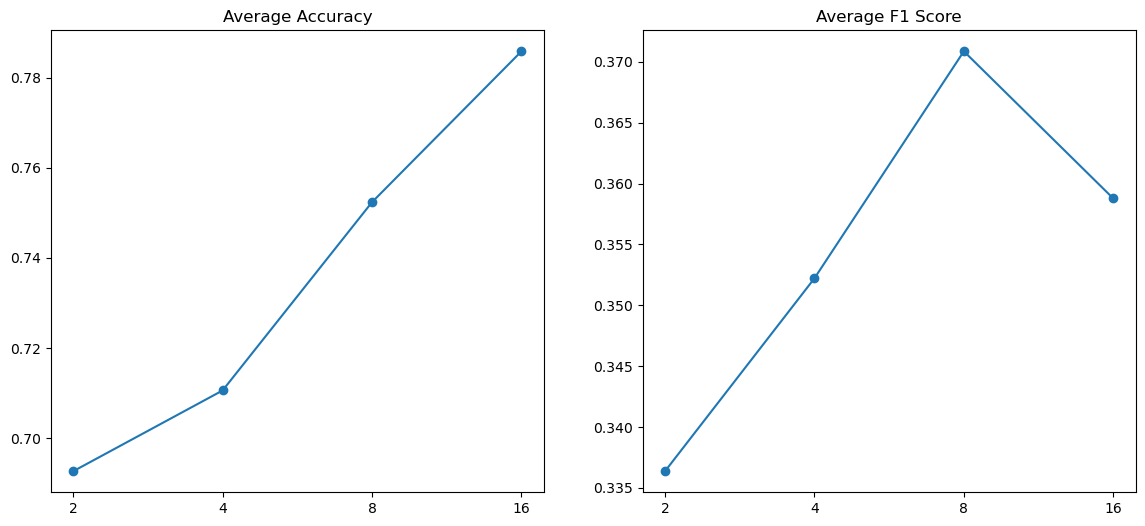

In [62]:
ttau_ml_feats = [
    'BrunetIndex', 'RatioVerb', 'RatioNoun', 'HonoreStatistic', '# ORDINAL (participant)',
    'AvgVPTypeLengthEmbedded', 'VPTypeRate', 'proportion_below_threshold_0', 'MATTR (participant)',
    'tree_height (participant)', 'PPTypeRate', 'VPProportion', 'NPTypeRate',
    '# utterances (participant)', 'VP_to_AUX_VP (participant)', '# NOUN (participant)',
    'DisfluencyFrequency', 'RatioCoordinate', '# TIME (participant)', 'VP_to_VBG (participant)',
    'MSTTR (participant)', 'avg_cos_dist', 'proportion_below_threshold_0.3', 'AvgVPTypeLengthNonEmbedded',
    'VP_to_AUX_ADJP (participant)', '# CCONJ (participant)', 'INTJ_to_UH (participant)',
    '# VERB (participant)', '# NUM (participant)', '# PROPN (participant)'
]

ttau_ml_accs, ttau_ml_f1s = check_top_features(X_ttau, y_ttau, ttau_ml_feats)
plot_acc_and_f1(ttau_ml_accs, ttau_ml_f1s, ttau_ml_feats, 'tTau_AB42Positivity (ML Approach)')

#### Statistical Approach (F_Classif)


Checking top 2 features


100%|██████████| 1000/1000 [03:23<00:00,  4.91it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:31<00:00,  4.73it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:31<00:00,  4.72it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:48<00:00,  3.46it/s]


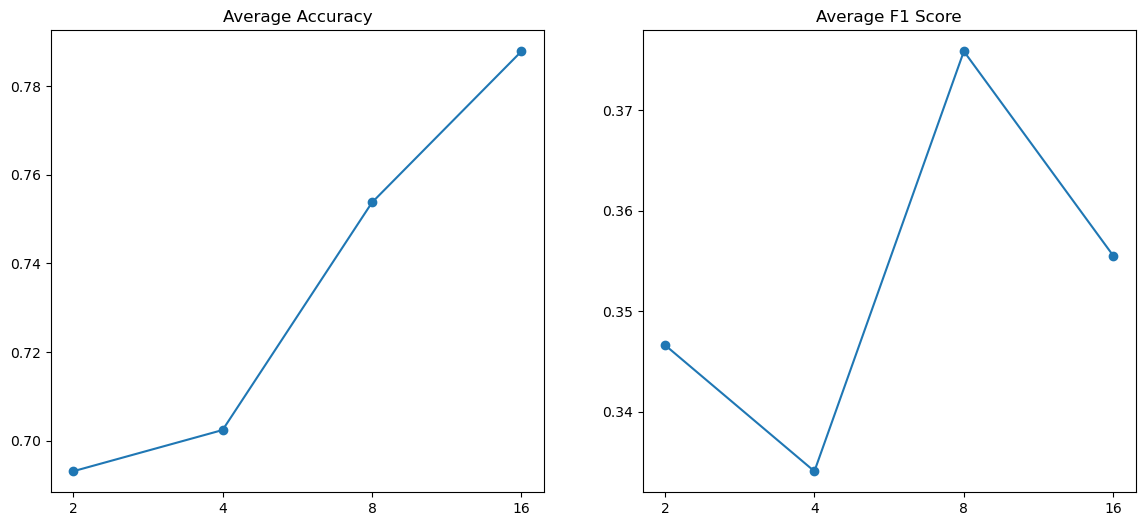

In [63]:
ttau_f_classif_feats = [
    '# VERB (participant)', '# ADV (participant)', '# PERSON (participant)', 'NP_to_PRP (participant)',
    '# CCONJ (participant)', '# PROPN (participant)', '# unique lemmas (participant)', '# TIME (participant)',
    '# ADJ (participant)', '# ORDINAL (participant)', '# ADP (participant)', 'tree_height (participant)',
    '# named entities (participant)', '# ORG (participant)', '# SCONJ (participant)', '# PUNCT (participant)'
]

ttau_f_classif_accs, ttau_f_classif_f1s = check_top_features(X_ttau, y_ttau, ttau_ml_feats)
plot_acc_and_f1(ttau_f_classif_accs, ttau_f_classif_f1s, ttau_f_classif_feats, 'tTau_AB42Positivity (Stat Approach - F_Classif)')

#### Statistical Approach (Mutual Information)


Checking top 2 features


100%|██████████| 1000/1000 [03:27<00:00,  4.82it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:33<00:00,  4.68it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:33<00:00,  4.68it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:49<00:00,  3.45it/s]


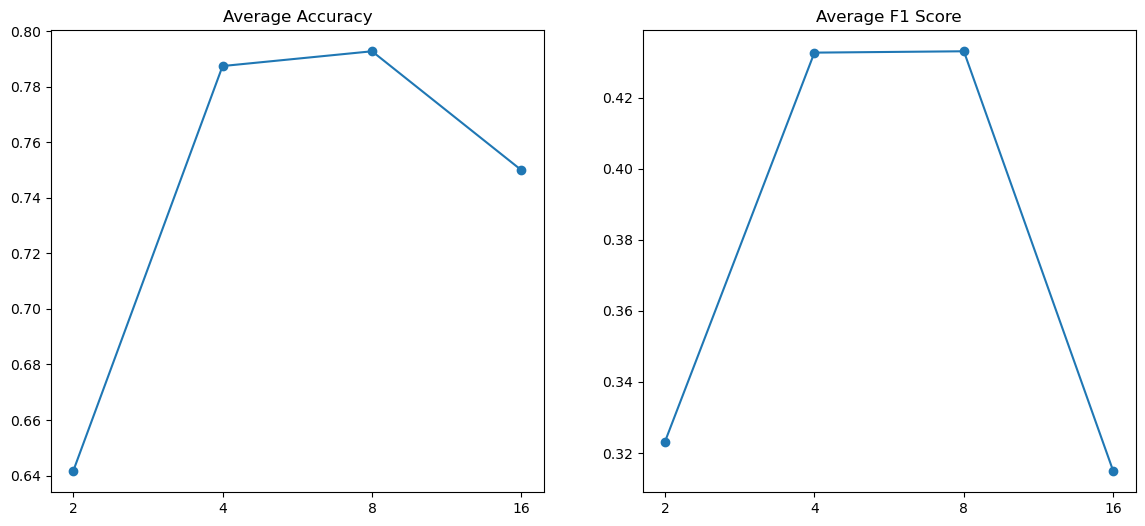

In [64]:
ttau_mutual_info_feats = [
    '# named entities (participant)', '# NOUN (participant)', '# ORDINAL (participant)', 'AvgVPTypeLengthEmbedded',
    'VPTypeRate', 'RatioNoun', 'BrunetIndex', 'NPTypeRate', 'proportion_below_threshold_0', 'RatioVerb',
    'MeanWordLength', '# TIME (participant)', '# NUM (participant)', '# unique named entities (participant)',
    'avg_cos_dist', 'NP_to_DT_NN (participant)', '# unique lemmas (participant)', 'AvgVPTypeLengthNonEmbedded',
    '# GPE (participant)', '# CCONJ (participant)', 'ADVP_to_RB (participant)', 'VP_to_VBG (participant)',
    '# SCONJ (participant)', 'tree_height (participant)', '# CARDINAL (participant)', 'VP_to_AUX (participant)',
    '# INTJ (participant)', 'VPProportion', 'AvgNPTypeLengthNonEmbedded', 'NumberOfNID'
]

ttau_mutual_info_accs, ttau_mutual_info_f1s = check_top_features(X_ttau, y_ttau, ttau_mutual_info_feats)
plot_acc_and_f1(ttau_mutual_info_accs, ttau_mutual_info_f1s, ttau_mutual_info_feats, 'tTau_AB42Positivity (Stat Approach - Mutual Information)')

#### Forward Selection Approach


Checking top 2 features


100%|██████████| 1000/1000 [03:09<00:00,  5.29it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:21<00:00,  4.95it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:27<00:00,  4.82it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:42<00:00,  3.55it/s]


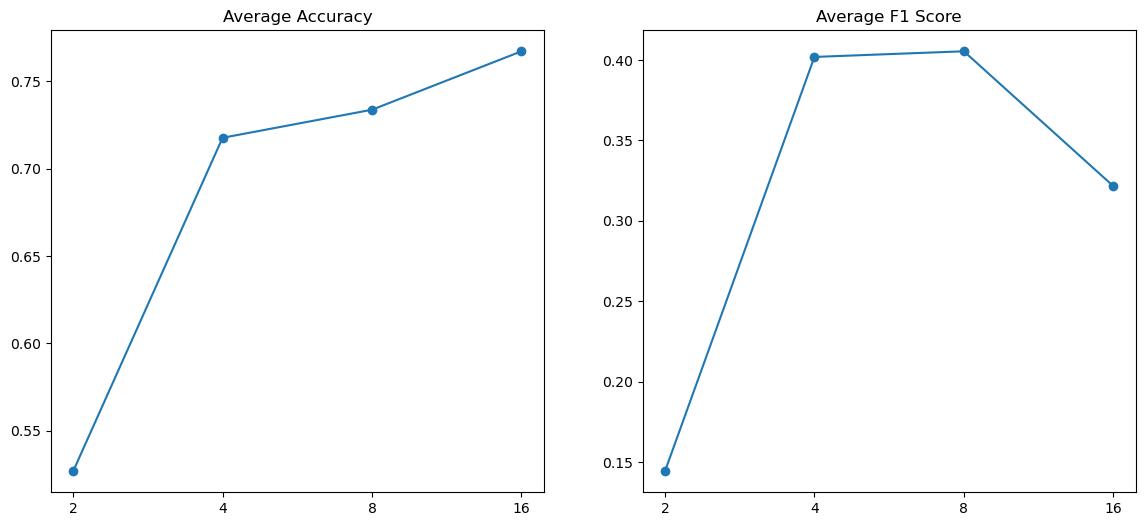

In [65]:
ttau_fs_feats = [
    'ADVP_to_RB (participant)', 'VP_to_VBG_PP (participant)', 'VP_to_VBD_NP (participant)', '# ORDINAL (participant)',
    'min_cos_dist', '# named entities (participant)', '# NOUN (participant)', 'NumberOfNID', 'AvgVPTypeLengthEmbedded',
    '# X (participant)', 'RatioNoun', 'VPTypeRate', '# PERSON (participant)', '# unique named entities (participant)',
    '# TIME (participant)', '# unique lemmas (participant)', '# NUM (participant)', '# unique tokens (participant)',
    '# ADV (participant)', 'proportion_below_threshold_0', '# tokens (participant)', '# SCONJ (participant)',
    'NP_to_DT_NN (participant)', 'BrunetIndex', 'MTLD (participant)', 'NPTypeRate', '# DATE (participant)',
    'RatioVerb', 'VPProportion', '# INTJ (participant)'
]

ttau_fs_accs, ttau_fs_f1s = check_top_features(X_ttau, y_ttau, ttau_fs_feats)
plot_acc_and_f1(ttau_fs_accs, ttau_fs_f1s, ttau_fs_feats, 'tTau_AB42Positivity (Forward Selection Approach)')

### tTau_AB42Positivity final results

For tTau we see that our possible best case scenario is obtained using the `top 8 features` from the `statistical approach (mutual information)`.</br>
In particular we have achieved an `accuracy of 0.7905 +- 0.0892` and an `F1 score of 0.4322 +- 0.2497`.

The top features are:
1. `# named entities (participant)`
2. `# NOUN (participant)`
3. `# ORDINAL (participant)`
4. `AvgVPTypeLengthEmbedded`
5. `VPTypeRate`
6. `RatioNoun`
7. `BrunetIndex`
8. `NPTypeRate`

### AB42_AB40Positivity

#### ML Approach


Checking top 2 features


100%|██████████| 1000/1000 [03:26<00:00,  4.85it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:35<00:00,  4.63it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:30<00:00,  4.74it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:46<00:00,  3.49it/s]


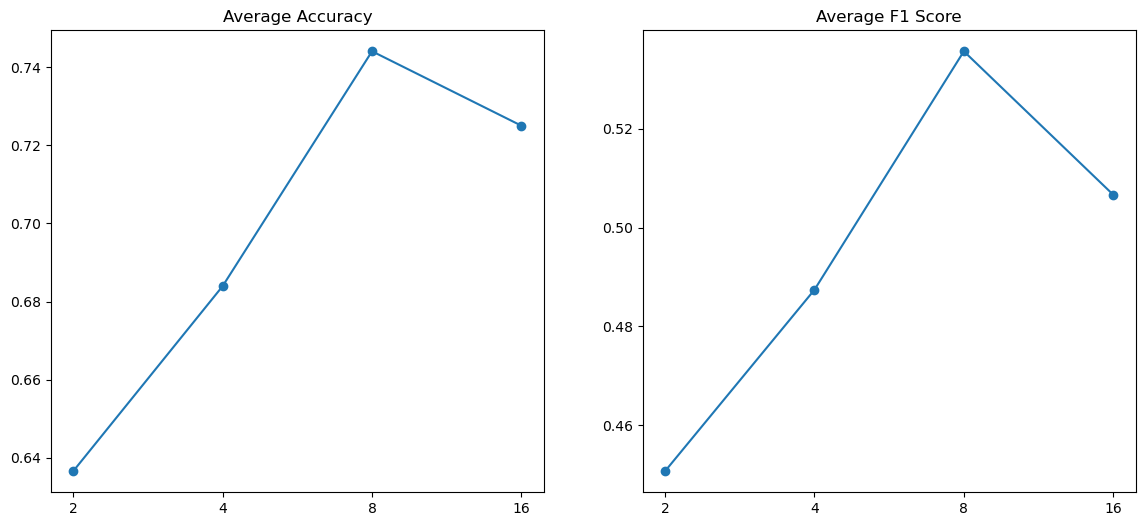

In [66]:
ab42_ml_feats = [
    'BrunetIndex', '# ORDINAL (participant)', 'RatioNoun', '# TIME (participant)', 'RatioVerb',
    'tree_height (participant)', 'VPTypeRate', 'MATTR (participant)', 'HonoreStatistic',
    '# NOUN (participant)', '# PROPN (participant)', 'VP_to_AUX_VP (participant)', 'NPTypeRate',
    'AvgVPTypeLengthEmbedded', '# unique named entities (participant)', 'VP_to_AUX_ADJP (participant)',
    '# CCONJ (participant)', 'proportion_below_threshold_0.3', 'AvgNPTypeLengthNonEmbedded',
    '# NUM (participant)', '# utterances (participant)', '# named entities (participant)',
    'DisfluencyFrequency', 'AvgVPTypeLengthNonEmbedded', 'RatioCoordinate', '# ADP (participant)',
    'Maas (participant)', 'VPProportion', '# PUNCT (participant)', 'PPTypeRate'
]

ab42_ml_accs, ab42_ml_f1s = check_top_features(X_ab42, y_ab42, ab42_ml_feats)
plot_acc_and_f1(ab42_ml_accs, ab42_ml_f1s, ab42_ml_feats, 'ab42_AB42Positivity (ML Approach)')

#### Statistical Approach (F_Classif)


Checking top 2 features


100%|██████████| 1000/1000 [03:25<00:00,  4.86it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:32<00:00,  4.72it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:33<00:00,  4.69it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:48<00:00,  3.47it/s]


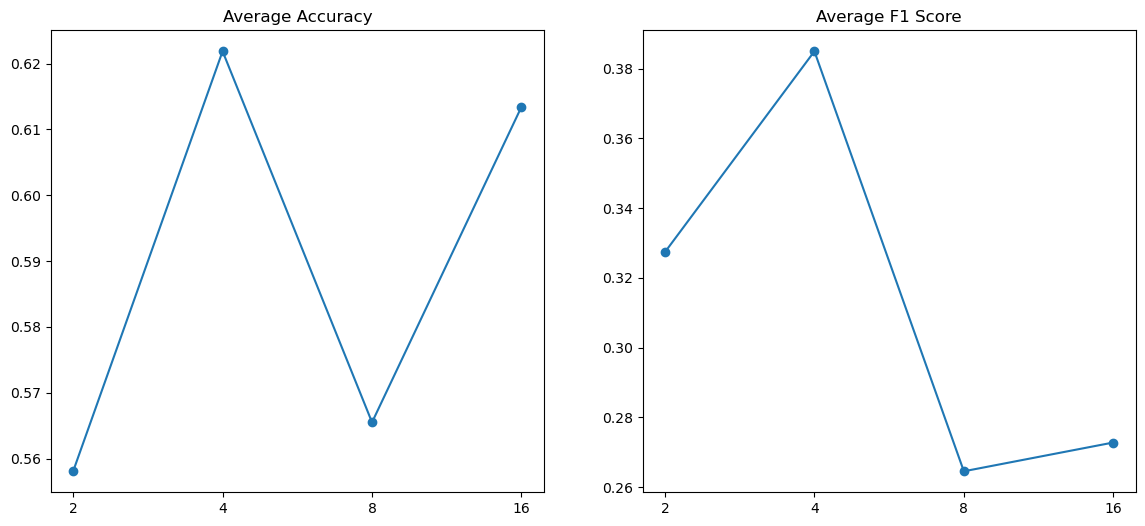

In [67]:
ab42_f_classif_feats = [
    '# ADV (participant)', '# CCONJ (participant)', '# PROPN (participant)', '# NUM (participant)',
    '# PART (participant)', '# PUNCT (participant)', 'tree_height (participant)', '# VERB (participant)',
    '# ADP (participant)', 'NP_to_PRP (participant)', '# named entities (participant)', '# ORG (participant)',
    '# unique named entities (participant)', '# TIME (participant)', '# utterances (participant)', '# INTJ (participant)'
]

ab42_f_classif_accs, ab42_f_classif_f1s = check_top_features(X_ab42, y_ab42, ab42_f_classif_feats)
plot_acc_and_f1(ab42_f_classif_accs, ab42_f_classif_f1s, ab42_f_classif_feats, 'ab42_AB42Positivity (Statistical Approach - F_Classif)')

#### Statistical Approach (Mutual Information)


Checking top 2 features


100%|██████████| 1000/1000 [03:24<00:00,  4.88it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:31<00:00,  4.73it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:28<00:00,  4.79it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:43<00:00,  3.53it/s]


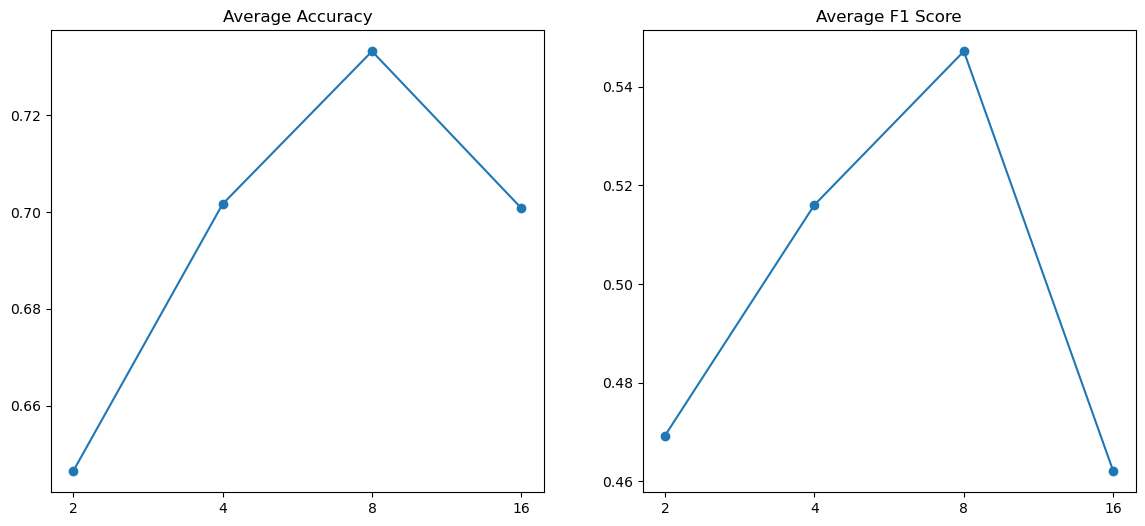

In [68]:
ab42_mutual_info_feats = [
    '# NOUN (participant)', 'VPTypeRate', '# PROPN (participant)', 'RatioVerb', 'NumberOfNID',
    'RatioNoun', '# ORDINAL (participant)', 'avg_cos_dist', 'tree_height (participant)', 
    '# CCONJ (participant)', '# named entities (participant)', 'AvgVPTypeLengthEmbedded',
    'AvgPPTypeLengthEmbedded', '# unique named entities (participant)', '# TIME (participant)',
    'DisfluencyFrequency', 'VP_to_AUX_VP (participant)', '# ADV (participant)', '# NUM (participant)',
    '# INTJ (participant)', 'NPTypeRate', 'VP_to_AUX (participant)', '# tokens (participant)',
    '# ADP (participant)', 'BrunetIndex', 'HonoreStatistic', '# PRON (participant)',
    'AvgVPTypeLengthNonEmbedded', '# PERSON (participant)', '# AUX (participant)'
]

ab42_mutual_info_accs, ab42_mutual_info_f1s = check_top_features(X_ab42, y_ab42, ab42_mutual_info_feats)
plot_acc_and_f1(ab42_mutual_info_accs, ab42_mutual_info_f1s, ab42_mutual_info_feats, 'ab42_AB42Positivity (Statistical Approach - Mutual Information)')

#### Forward Selection Approach


Checking top 2 features


100%|██████████| 1000/1000 [03:09<00:00,  5.28it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:10<00:00,  5.25it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:24<00:00,  4.90it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:36<00:00,  3.62it/s]


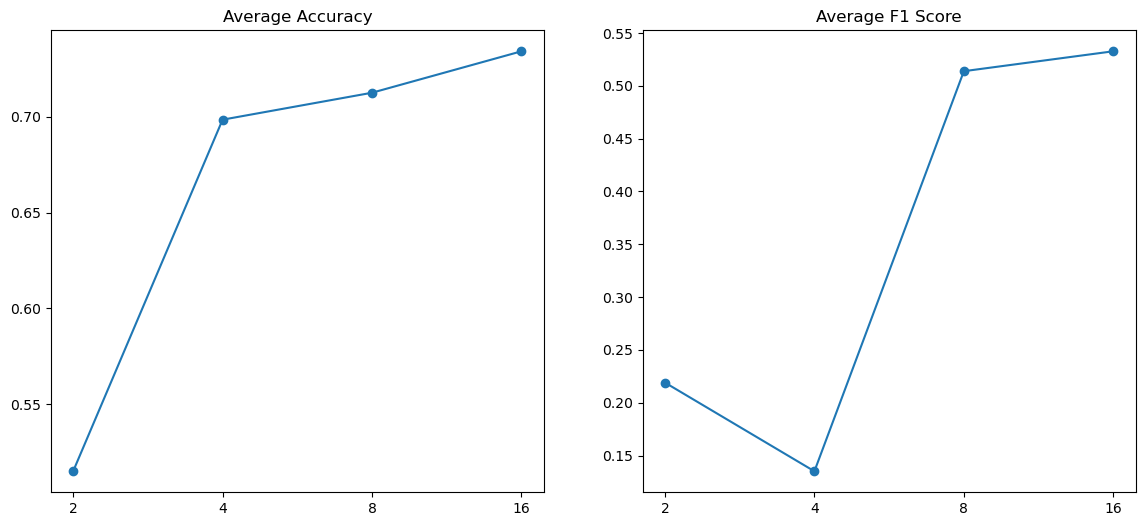

In [69]:
ab42_fs_feats = [
    'ADVP_to_RB (participant)', 'VP_to_VBD_NP (participant)', 'VP_to_VBG_PP (participant)', 'NumberOfNID',
    'min_cos_dist', 'AvgVPTypeLengthEmbedded', '# NOUN (participant)', '# ORDINAL (participant)',
    '# TIME (participant)', 'RatioVerb', 'VPTypeRate', '# unique lemmas (participant)', 'RatioNoun',
    'ROOT_to_FRAG (participant)', 'MATTR (participant)', '# X (participant)',
    '# unique named entities (participant)', 'BrunetIndex', 'PProportion', 'proportion_below_threshold_0.5',
    '# ADV (participant)', 'NPTypeRate', '# PROPN (participant)', '# PRON (participant)', 'MeanWordLength',
    '# DET (participant)', '# ADP (participant)', '# ORG (participant)', '# SCONJ (participant)', 'avg_cos_dist'
]

ab42_fs_accs, ab42_fs_f1s = check_top_features(X_ab42, y_ab42, ab42_fs_feats)
plot_acc_and_f1(ab42_fs_accs, ab42_fs_f1s, ab42_fs_feats, 'ab42_AB42Positivity (Forward Selection Approach)')

#### Mixed Sets

In [ ]:
ab42_mixed_features = []
a, b = ab42_ml_feats[:8], ab42_mutual_info_feats[:8]
for idx in range(max(len(a), len(b))):
    if idx < len(a):
        if a[idx] not in ab42_mixed_features:
            ab42_mixed_features.append(a[idx])
    if idx < len(b):
        if b[idx] not in ab42_mixed_features:
            ab42_mixed_features.append(b[idx])

In [165]:
ab42_top_accs, ab42_top_f1s = check_top_features(X_ab42, y_ab42, ab42_mixed_features, [2,4,8,12])


Checking top 2 features


100%|██████████| 1000/1000 [03:29<00:00,  4.78it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:34<00:00,  4.65it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:34<00:00,  4.66it/s]



Checking top 12 features


100%|██████████| 1000/1000 [03:42<00:00,  4.50it/s]


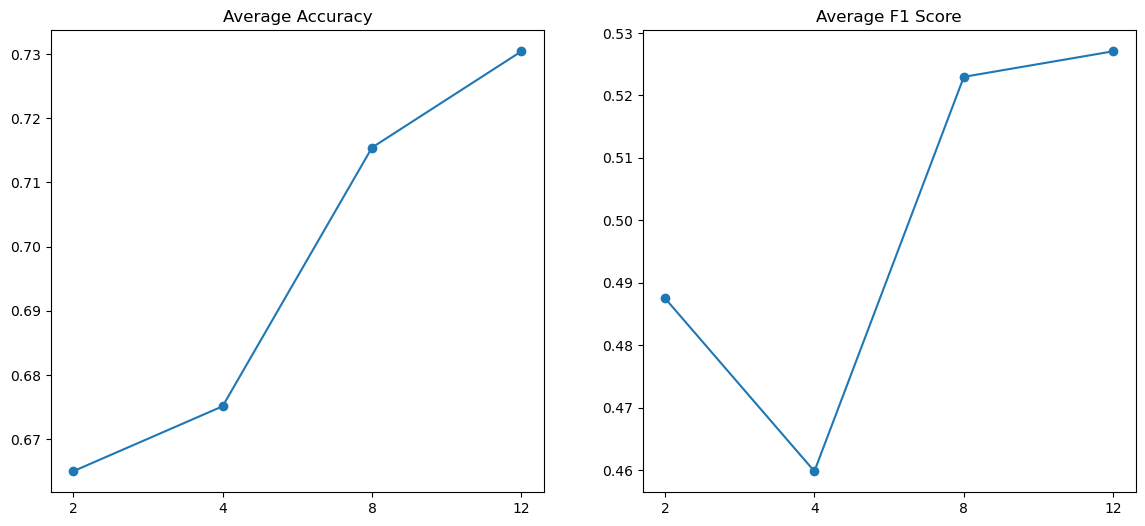

**********   Top 2   **********
Accuracy: 0.665 +- 0.10485108487755383
F1 Score: 0.4875522684831508 +- 0.16489208669705352

**********   Top 4   **********
Accuracy: 0.675125 +- 0.09974177597676913
F1 Score: 0.4598480935730936 +- 0.17409007774238802

**********   Top 8   **********
Accuracy: 0.7154375 +- 0.09801129957178406
F1 Score: 0.5229795482295482 +- 0.1687671775262643

**********   Top 12   **********
Accuracy: 0.7304375 +- 0.09744852407168618
F1 Score: 0.5270711677211677 +- 0.1803208336437448



In [166]:
plot_acc_and_f1(ab42_top_accs, ab42_top_f1s, ab42_mixed_features, 'AB42_AB40Positivity (Mixed Set)', [2,4,8,12], True)

In [167]:
ab42_final_mi_accs, ab42_final_mi_f1s = check_top_features(X_ab42, y_ab42, ab42_mutual_info_feats[:8], [8])
print(f'Mean: {ab42_final_mi_accs[0][0]} +- {ab42_final_mi_accs[1][0]}')
print(f'F1:   {ab42_final_mi_f1s[0][0]} +- {ab42_final_mi_f1s[1][0]}')


Checking top 8 features


100%|██████████| 1000/1000 [03:34<00:00,  4.66it/s]

Mean: 0.7255 +- 0.10008465167047342
F1:   0.5397261405261404 +- 0.1731555597536187


In [168]:
ab42_final_ml_accs, ab42_final_ml_f1s = check_top_features(X_ab42, y_ab42, ab42_ml_feats[:8], [8])
print(f'Mean: {ab42_final_ml_accs[0][0]} +- {ab42_final_ml_accs[1][0]}')
print(f'F1:   {ab42_final_ml_f1s[0][0]} +- {ab42_final_ml_f1s[1][0]}')


Checking top 8 features


100%|██████████| 1000/1000 [03:34<00:00,  4.65it/s]

Mean: 0.7421875 +- 0.09406976716113419
F1:   0.53054777999778 +- 0.18718467410199555


### AB42_AB40Positivity final results

The analysis of final results for this target has been a little more complex, given that we have 3 similar final results.</br>

|                     | Accuracy         | F1 Score         |
|---------------------|------------------|------------------|
| `Top 8 ML`          | 0.7422 +- 0.0941 | 0.5305 +- 0.1872 |
| `Top 8 mutual info` | 0.7255 +- 0.1001 | 0.5397 +- 0.1732 |
| `Mixed set`         | 0.7304 +- 0.0974 | 0.5271 +- 0.1803 |

In the end, the `top 8 ML features` achieve the top accuracy while only having a small decrease in F1 score (less than 1%).

The features are:
1. `BrunetIndex`
2. `# ORDINAL (participant)`
3. `RatioNoun`
4. `# TIME (participant)`
5. `RatioVerb`
6. `tree_height (participant)`
7. `VPTypeRate`
8. `MATTR (participant)`

# Explainability

Our analysis yielded good results, but in order to strengthen our confidence in our work we need to explain our results.</br>
In particular, we are going to use the SHAP values in order to understand how the top features influence our predictions, and we'll compute the correlation between different feature groups and the target labels.

In [55]:
def load_exp(selected_feats, target, typ=int):
    # Load the entire csv file
    data = pd.read_csv('data/no_audio_corrected.csv')

    # Join labels and data so that truth values are aligned with original data
    lbls = LABELS[['id', target]]
    temp = data.merge(lbls, on='id', how='left')
    temp = temp.dropna()
    # Extract only the ground truths
    labels = temp[['id', target]].set_index('id').astype(typ)
    data = temp.drop(target, axis=1)
    data = data.set_index('id')
    # Keep just the selected features
    data = data[selected_feats]
    data = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns, index=data.index)
    data.columns = list(map(lambda x: x.replace(' (participant)', ''), data.columns.to_list()))
    data[target] = labels
    return data.reset_index()

In [50]:
import seaborn as sns

MOCA_EXP_FEATS = [
    '# unique tokens (participant)', '# tokens (participant)', '# unique lemmas (participant)', 'VP_to_VBG (participant)',
    'NPTypeRate', '# DATE (participant)', '# utterances (participant)', '# named entities (participant)'
]
TTAU_EXP_FEATS = [
    '# named entities (participant)', '# NOUN (participant)', '# ORDINAL (participant)', 'AvgVPTypeLengthEmbedded',
    'VPTypeRate', 'RatioNoun', 'BrunetIndex', 'NPTypeRate'
]
AB42_EXP_FEATS = [
    'BrunetIndex', '# ORDINAL (participant)', 'RatioNoun', '# TIME (participant)',
    'RatioVerb', 'tree_height (participant)', 'VPTypeRate', 'MATTR (participant)'
]

TARGETS = ['tTau_AB42Positivity', 'AB42_AB40Positivity', 'MOCA_impairment']

## Variable Correlation

In [59]:
from scipy.stats.stats import pearsonr, spearmanr

def get_correlation(targets, corr_func, typ=int, special=None, filt= None, encoding=None):
    series, annots = [], []
    for idx, (feats, target) in enumerate(zip([TTAU_EXP_FEATS, AB42_EXP_FEATS, MOCA_EXP_FEATS], targets)):
        corr_df = load_exp(feats, target, typ).drop('id', axis=1)
        # If any filter is present, use it before everything
        if filt:
            corr_df = filt(corr_df)
        corr_target = corr_df[target]
        corr_df = corr_df.drop(target, axis=1)
        # Encode target variable if needed
        if encoding:
            corr_target = corr_target.apply(encoding)

        corr_coeffs, p_vals = [], []
        for col in corr_df.columns:
            corr = corr_func(corr_df[col], corr_target)
            corr_coeffs.append(round(corr[0], 2))
            p_vals.append(round(corr[1], 2))

        if target == 'tTau_AB42Positivity':
            fixed = corr_df.columns.to_list()
            fixed[3] = 'AvgVPType\nLengthEmbedded'
            corr_df.columns = fixed

        zipped = list(zip(corr_coeffs, p_vals, corr_df.columns.to_list()))
        corr_coeffs, p_vals, indx = zip(*sorted(zipped, key=lambda x: x[0], reverse=True))
        series.append(pd.DataFrame(corr_coeffs, index=indx, columns=[target if not special else special[idx]]))
        annots.append(pd.DataFrame([f'{x}\n(p-val {y})' for x, y in zip(corr_coeffs, p_vals)], index=indx, columns=[target if not special else special[idx]]))
    return series, annots

In [44]:
def plot_correlation(series, annots, title, order=[0,1,2]):
    fig, axs = plt.subplots(ncols=3, figsize=(12,8))
    fig.suptitle(title, size=16)
    sns.heatmap(series[0], annot=annots[0], robust=True, cmap=sns.color_palette("coolwarm_r", as_cmap=True), linewidth=0.1, ax=axs[order[0]], fmt = '')
    sns.heatmap(series[1], annot=annots[1], robust=True, cmap=sns.color_palette("coolwarm_r", as_cmap=True), linewidth=0.1, ax=axs[order[1]], fmt = '')
    sns.heatmap(series[2], annot=annots[2], robust=True, cmap=sns.color_palette("coolwarm_r", as_cmap=True), linewidth=0.1, ax=axs[order[2]], fmt = '')
    plt.subplots_adjust(wspace=1.4, top=0.92)
    plt.show()

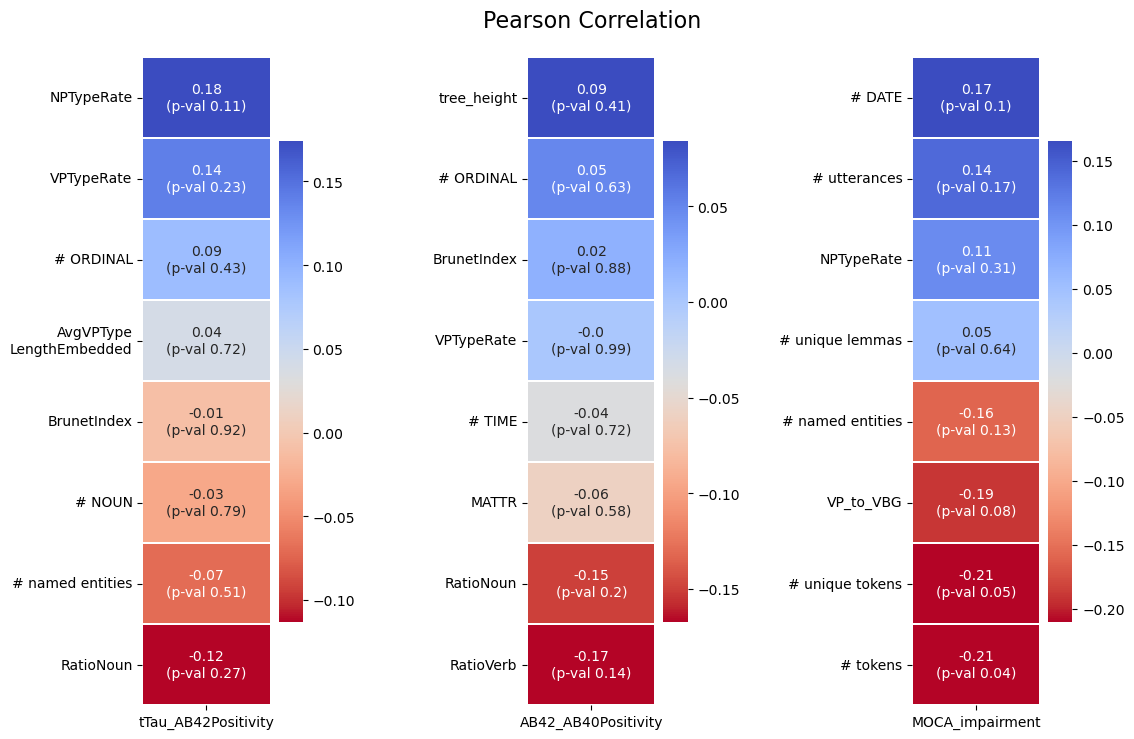

In [45]:
series, annots = get_correlation(TARGETS, pearsonr)
plot_correlation(series, annots, "Pearson Correlation")

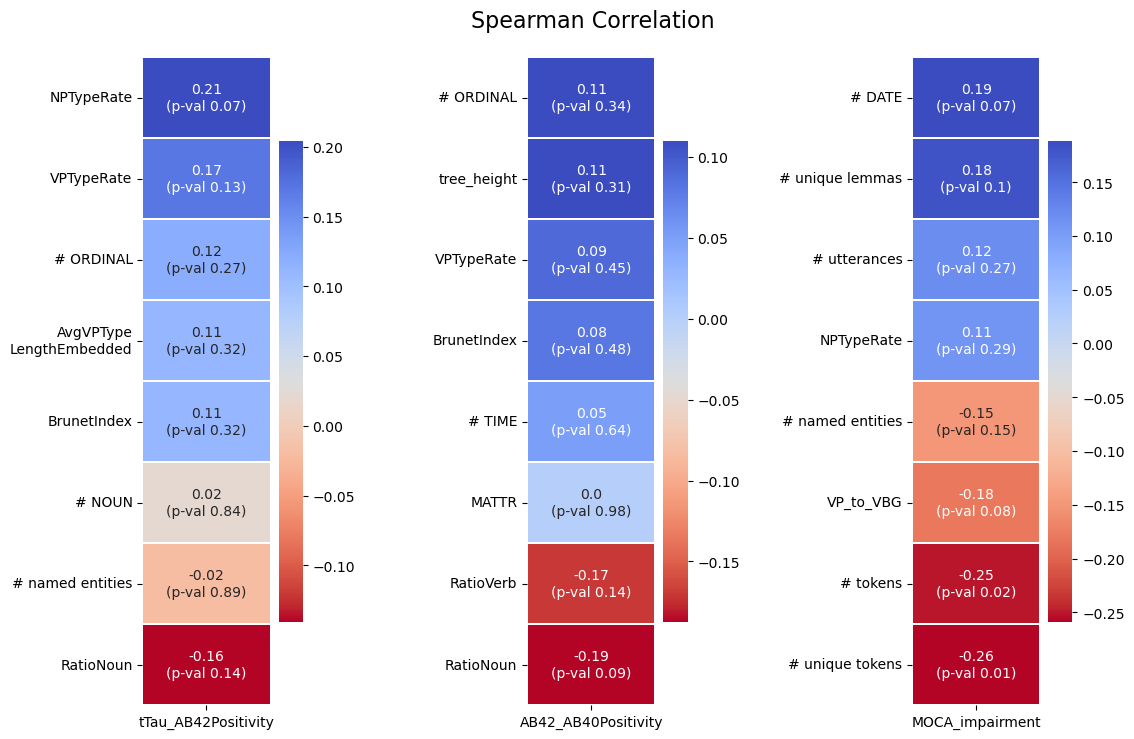

In [46]:
series, annots = get_correlation(TARGETS, spearmanr)
plot_correlation(series, annots, "Spearman Correlation")

## WRT Clinical Diagnosis

In [52]:
# Filters
def filter_ad(df: pd.DataFrame):
    return df.drop(df[df['DX1'] == 'MCI'].index)

def filter_mci(df: pd.DataFrame):
    return df.drop(df[df['DX1'] == 'Prob AD'].index)

In [53]:
# Encodings
def encode_ad_mci(x):
    if x == 'Normal' or x=='Normal-PD':
        return 0
    return 1

def encode_ad(x):
    if x == 'Prob AD':
        return 1
    return 0
        
def encode_mci(x):
    if x == 'MCI':
        return 1
    return 0


### Control vs Prob AD

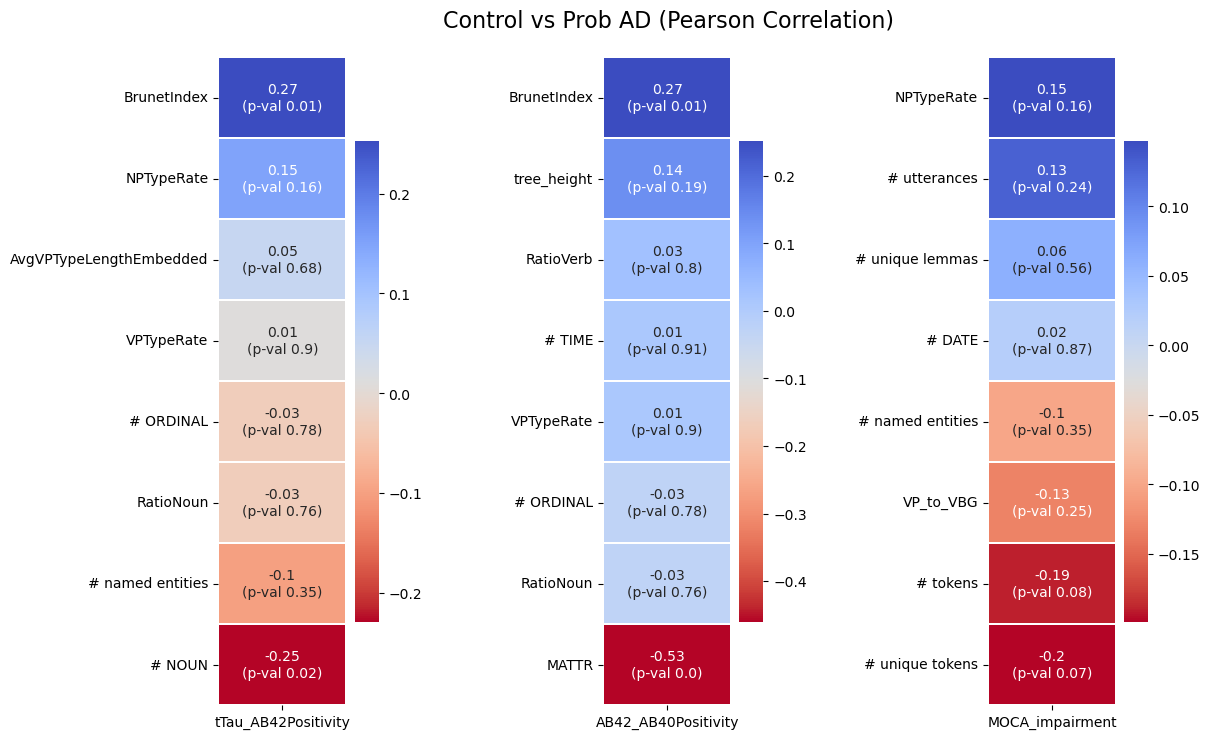

In [60]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], pearsonr, typ=str, special=TARGETS, filt=filter_ad, encoding=encode_ad)
plot_correlation(series, annots, "Control vs Prob AD (Pearson Correlation)")

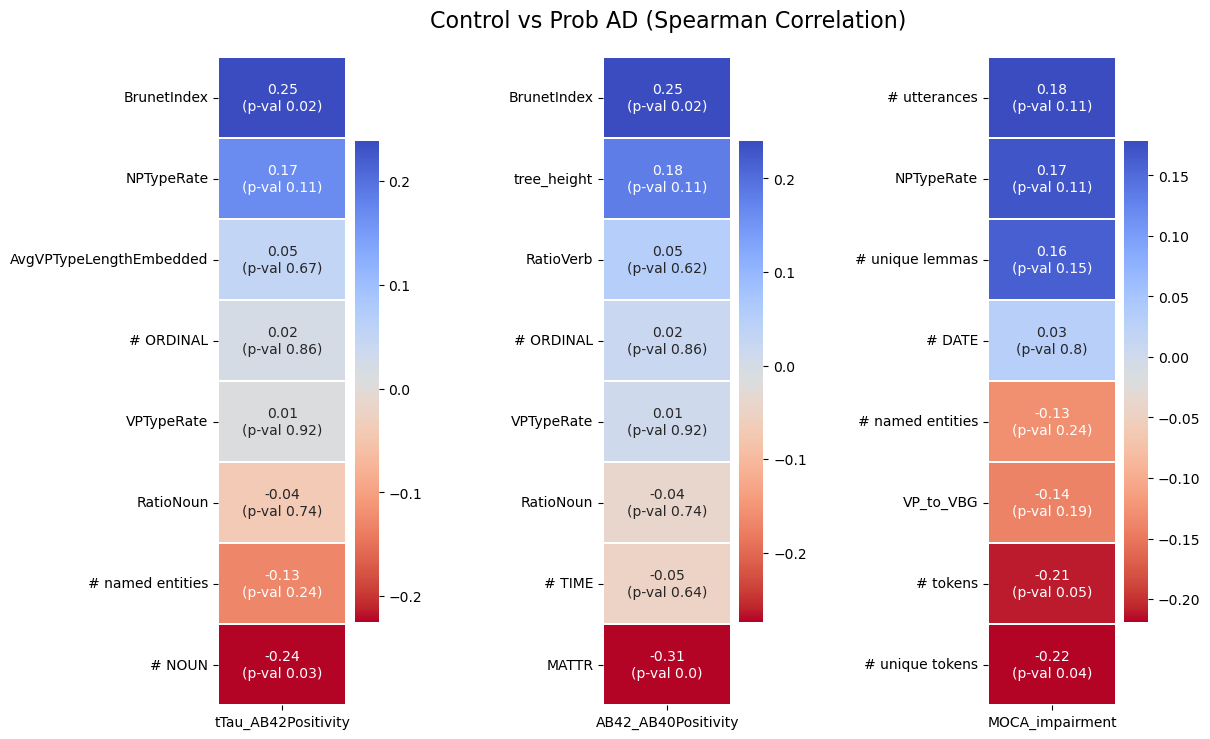

In [61]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], spearmanr, typ=str, special=TARGETS, filt=filter_ad, encoding=encode_ad)
plot_correlation(series, annots, "Control vs Prob AD (Spearman Correlation)")

### Control vs MCI

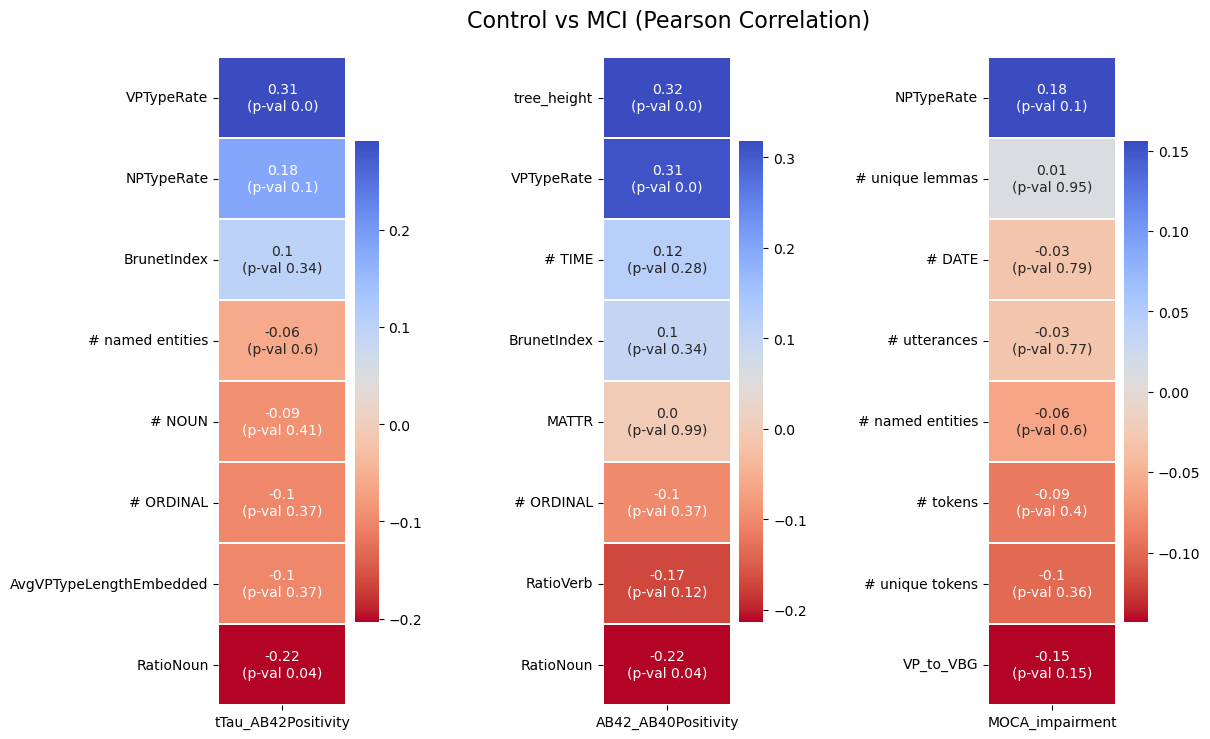

In [62]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], pearsonr, typ=str, special=TARGETS, filt=filter_mci, encoding=encode_mci)
plot_correlation(series, annots, "Control vs MCI (Pearson Correlation)")

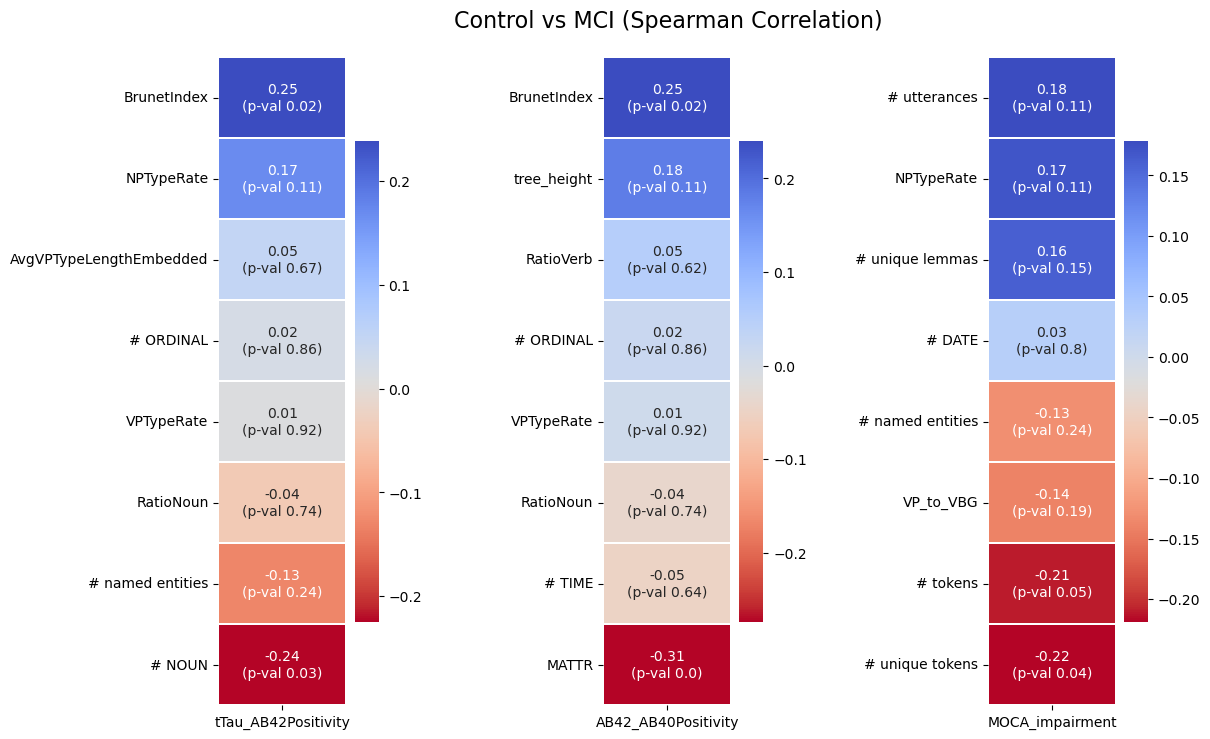

In [63]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], spearmanr, typ=str, special=TARGETS, filt=filter_ad, encoding=encode_ad)
plot_correlation(series, annots, "Control vs MCI (Spearman Correlation)")

### Control vs MCI & Prob AD

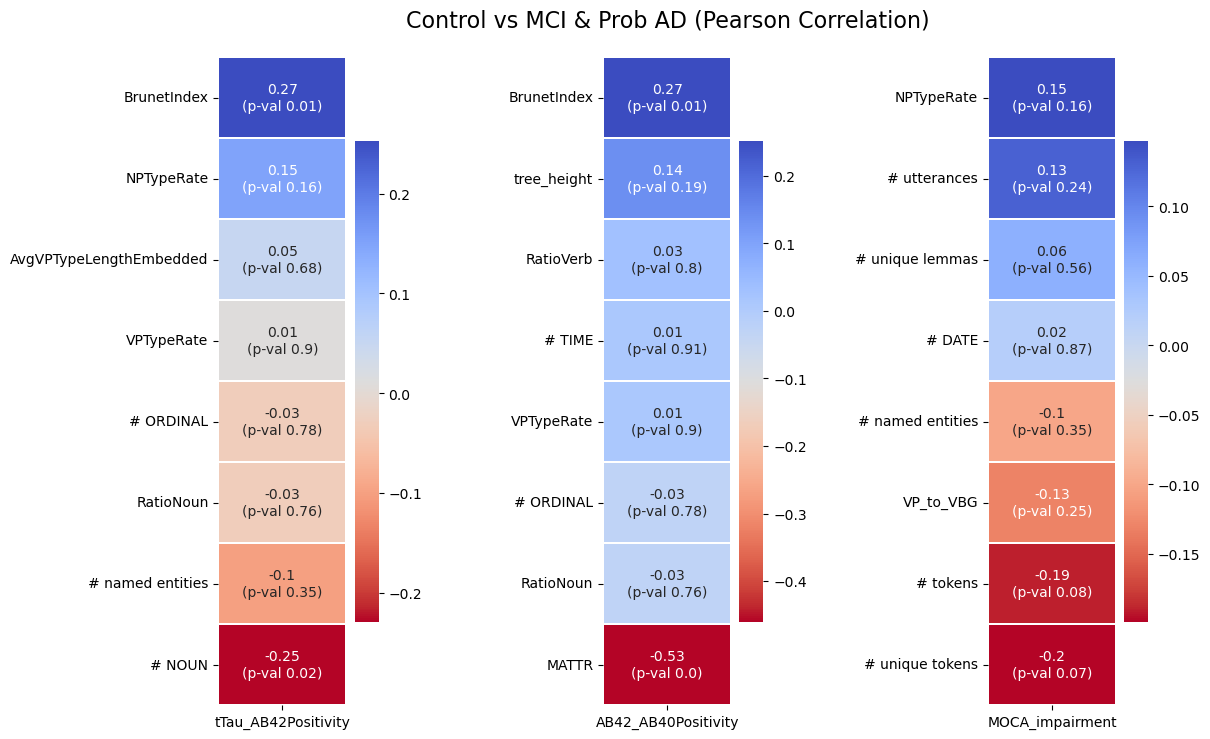

In [64]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], pearsonr, typ=str, special=TARGETS, filt=filter_ad, encoding=encode_ad)
plot_correlation(series, annots, "Control vs MCI & Prob AD (Pearson Correlation)")

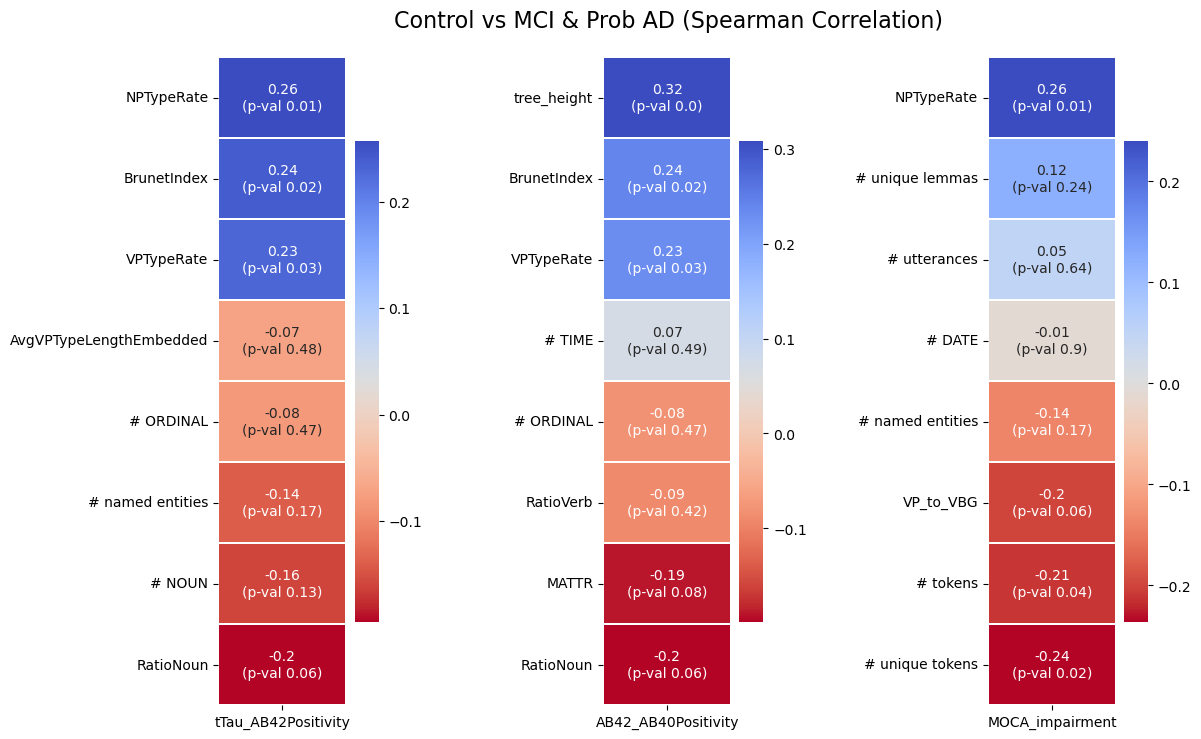

In [65]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], spearmanr, typ=str, special=TARGETS, encoding=encode_ad_mci)
plot_correlation(series, annots, "Control vs MCI & Prob AD (Spearman Correlation)")

## Shap Values

In [197]:
from sklearn.model_selection import StratifiedKFold

np.random.seed(42)
CV_REPETITIONS = 1000
N_ESTIMATORS = 200

In [199]:
# Use a dict to track the SHAP values of each observation per CV repitition
# And given that we have 2 classes, we can save the SHAP values for both classes separately
def populate_dictionaries(X, cv_repetitions):
    shap_values_per_cv_0 = dict()
    shap_values_per_cv_1 = dict()

    for sample in X.index:
        # Create keys for each sample
        shap_values_per_cv_0[sample] = {}
        shap_values_per_cv_1[sample] = {}
        # Then, keys for each CV fold within each sample
        for CV_repeat in range(cv_repetitions):
            shap_values_per_cv_0[sample][CV_repeat] = {}
            shap_values_per_cv_1[sample][CV_repeat] = {}
    return shap_values_per_cv_0, shap_values_per_cv_1

In [200]:
# Split the data into folds
def get_split(X: pd.DataFrame, y: pd.DataFrame, seed:int):
    CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    idx_train, idx_test = [], []
    # Loop through each fold and append the training & test indices to the empty lists above
    for fold in CV.split(X, y):
        idx_train.append(fold[0]), idx_test.append(fold[1])
    
    return idx_train, idx_test

In [201]:
def full_cv_run(X, y, idx, idx_train, idx_test, seed, shap_values_per_cv, n_estimators=200):
    # Loop through each outer fold and extract SHAP values 
    for outer_idx_train, outer_idx_test in zip(idx_train, idx_test):
        X_train, X_test = X.iloc[outer_idx_train, :], X.iloc[outer_idx_test, :]
        y_train = y.iloc[outer_idx_train]

        model = RandomForestClassifier(n_estimators=n_estimators, random_state=seed)
        model.fit(X_train, y_train)

        # Use SHAP to explain predictions
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

        # Extract SHAP information per fold per sample 
        for i, test_index in enumerate(outer_idx_test):
            shap_values_per_cv[0][test_index][idx] = shap_values[0][i]
            shap_values_per_cv[1][test_index][idx] = shap_values[1][i]

In [202]:
# Compute average Shap values, their Stdevs, and their min/max
def get_stats(df, shap_values_per_cv):
    average_shap_values, stds, ranges = [],[],[]
    for i in range(len(df)):
        df_per_obs = pd.DataFrame.from_dict(shap_values_per_cv[i]) # Get all SHAP values for sample number i
        # Get relevant statistics for every sample 
        average_shap_values.append(df_per_obs.mean(axis=1).values) 
        stds.append(df_per_obs.std(axis=1).values)
        ranges.append(df_per_obs.max(axis=1).values-df_per_obs.min(axis=1).values)

    return average_shap_values, stds, ranges

In [203]:
def explain(target, features, cv_repetitions, seeds):
    df = load_exp(features, target)
    X = df.drop(['id', target], axis=1)
    y = df[target]

    shap_values_per_cv_0, shap_values_per_cv_1 = populate_dictionaries(X, cv_repetitions)

    for idx in tqdm(range(cv_repetitions)):
        idx_train, idx_test = get_split(X, y, seeds[idx])
        full_cv_run(X, y, idx, idx_train, idx_test, seeds[idx], (shap_values_per_cv_0, shap_values_per_cv_1))

    
    average_shap_values_0, stds_0, ranges_0 = get_stats(df, shap_values_per_cv_0)
    average_shap_values_1, stds_1, ranges_1 = get_stats(df, shap_values_per_cv_1)

    return X, (average_shap_values_0, stds_0, ranges_0), (average_shap_values_1, stds_1, ranges_1)

In [207]:
def plot_shap_vals(X, average_values, label, cv_repetitions):
    shap.summary_plot(np.array(average_values), X, show = False)
    plt.title(f'Average SHAP values after {cv_repetitions}x cross-validation (class {label})')
    plt.show()

In [208]:
def plot_ranges(X, ranges: list, label: int):
    ranges = pd.DataFrame(ranges)
    ranges.columns = X.columns
    # Transpose dataframe to long form
    values, labels = [],[]
    for i in range(len(ranges.columns)):
        for j in range(len(ranges)):
            values.append(ranges.T[j][i])
            labels.append(ranges.columns[i])
    long_df = pd.DataFrame([values,labels]).T
    long_df.columns = ['Values', 'Features']


    title = f'Range of SHAP values per sample across all\ncross-validation repeats (class {label})'
    xlab, ylab = 'SHAP Value Variability', 'SHAP range per sample'
    sns.catplot(data = long_df, x = 'Features', y = 'Values').set(xlabel = xlab, ylabel = ylab,
                                                                                title = title)
    plt.xticks(rotation=45)
    plt.show()

### MOCA_impairment

In [209]:
MOCA_SEEDS = np.random.random_integers(100000, size=CV_REPETITIONS)
X_moca_exp, moca_class_0, moca_class_1 = explain('MOCA_impairment', MOCA_EXP_FEATS, CV_REPETITIONS, MOCA_SEEDS)

100%|██████████| 1000/1000 [15:51<00:00,  1.05it/s]


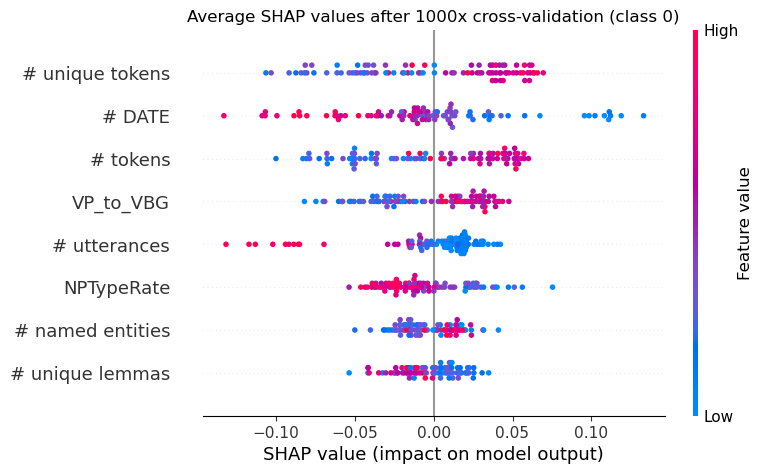

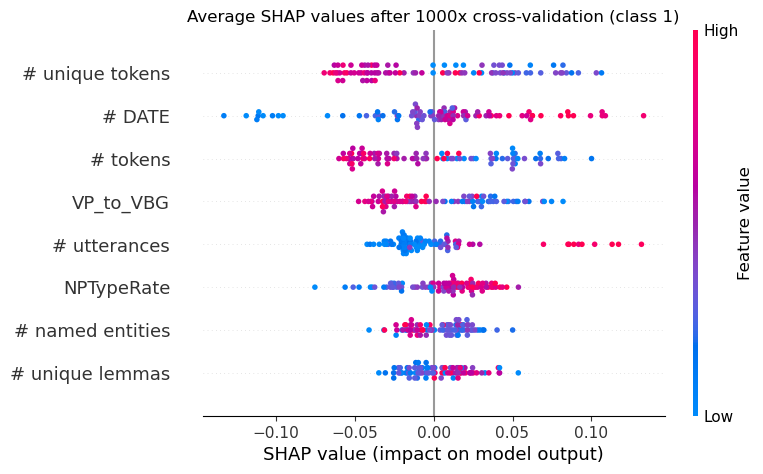

In [211]:
plot_shap_vals(X_moca_exp, moca_class_0[0], 0, CV_REPETITIONS)
plot_shap_vals(X_moca_exp, moca_class_1[0], 1, CV_REPETITIONS)

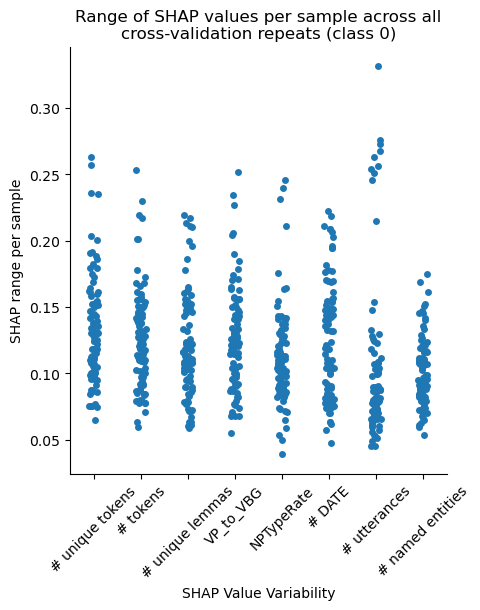

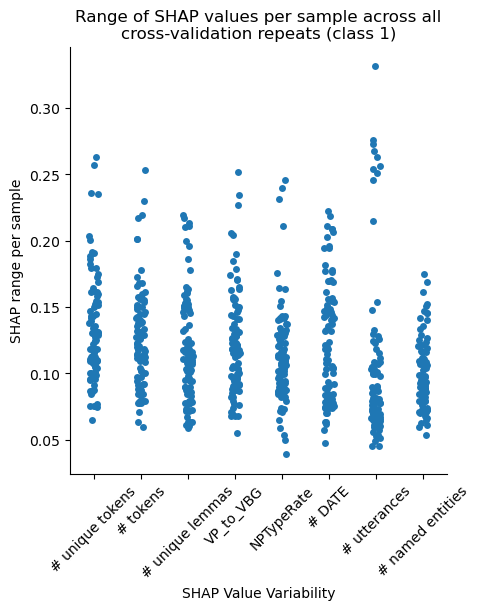

In [212]:
plot_ranges(X_moca_exp, moca_class_0[2], 0)
plot_ranges(X_moca_exp, moca_class_1[2], 1)

### tTau_AB42Positivity

In [213]:
TTAU_SEEDS = np.random.random_integers(100000, size=CV_REPETITIONS)
X_ttau_exp, ttau_class_0, ttau_class_1 = explain('tTau_AB42Positivity', TTAU_EXP_FEATS, CV_REPETITIONS, TTAU_SEEDS)

100%|██████████| 1000/1000 [15:32<00:00,  1.07it/s]


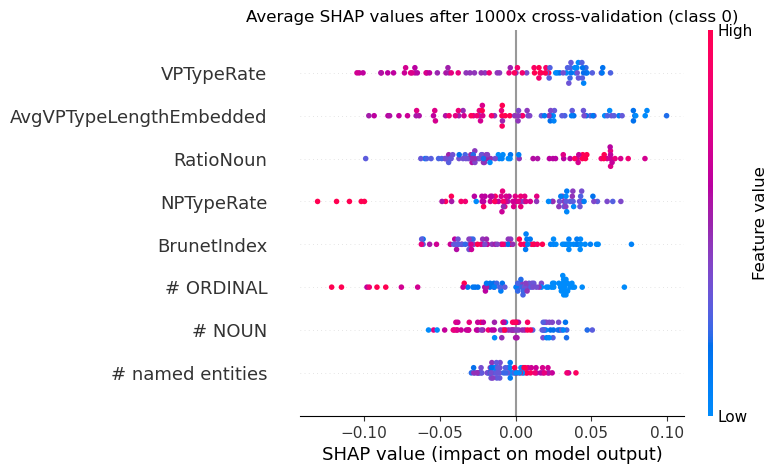

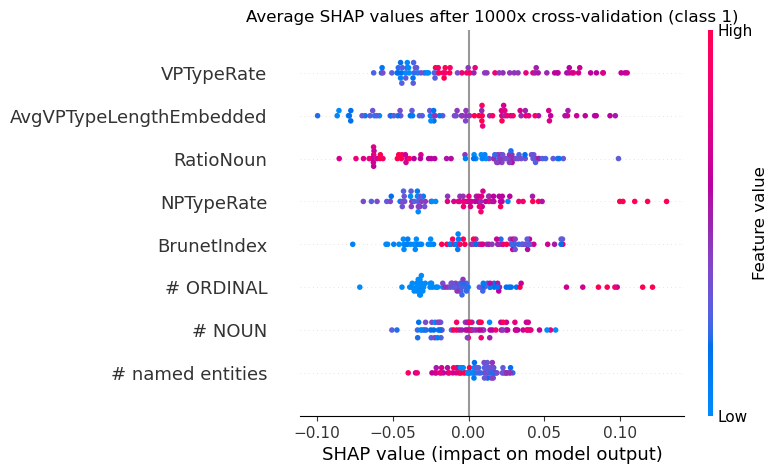

In [214]:
plot_shap_vals(X_ttau_exp, ttau_class_0[0], 0, CV_REPETITIONS)
plot_shap_vals(X_ttau_exp, ttau_class_1[0], 1, CV_REPETITIONS)

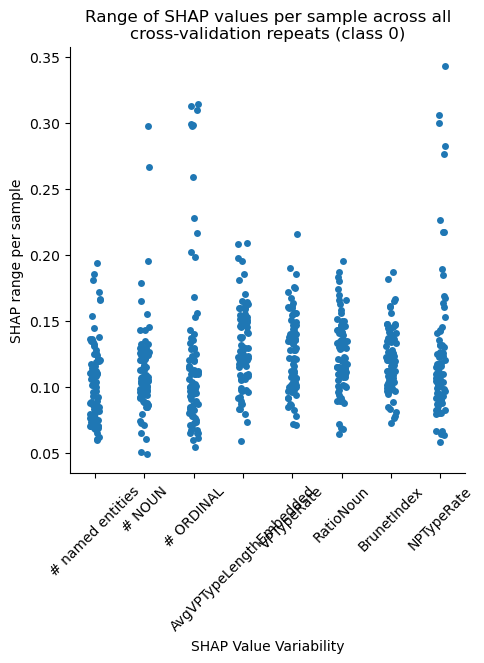

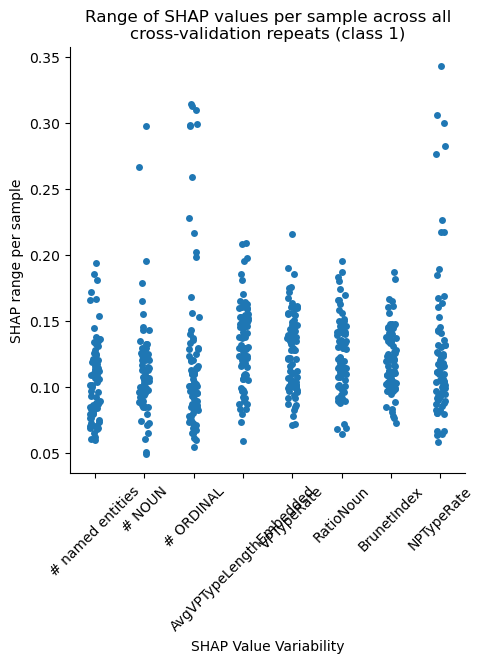

In [215]:
plot_ranges(X_ttau_exp, ttau_class_0[2], 0)
plot_ranges(X_ttau_exp, ttau_class_1[2], 1)

### AB42_AB40Positivity

In [216]:
AB42_SEEDS = np.random.random_integers(100000, size=CV_REPETITIONS)
X_ab42_exp, ab42_class_0, ab42_class_1 = explain('AB42_AB40Positivity', AB42_EXP_FEATS, CV_REPETITIONS, AB42_SEEDS)

100%|██████████| 1000/1000 [15:29<00:00,  1.08it/s]


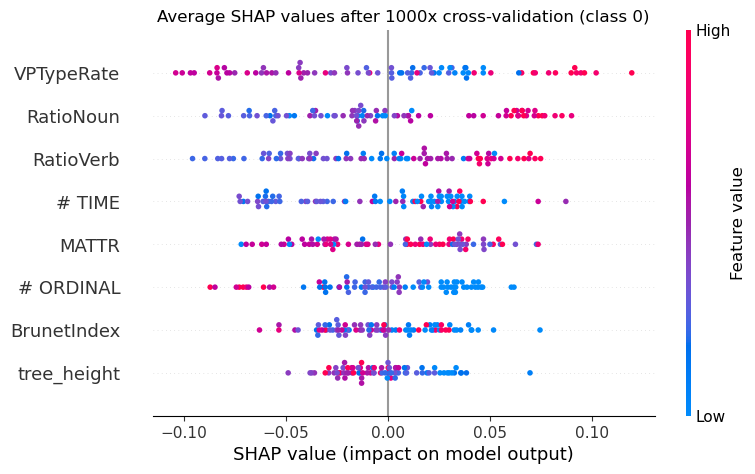

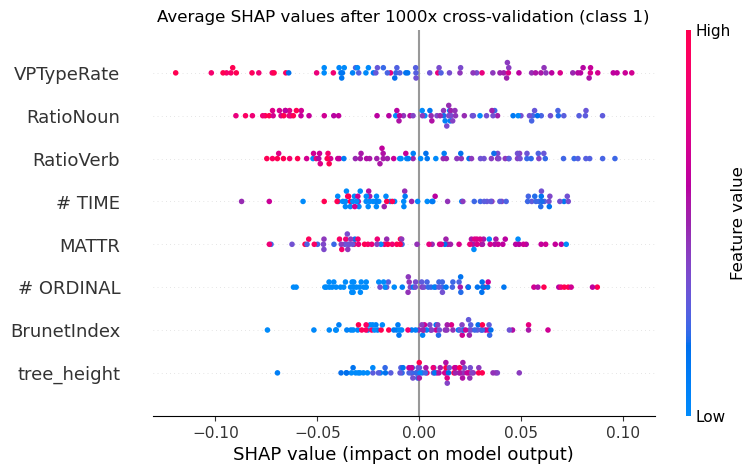

In [217]:
plot_shap_vals(X_ab42_exp, ab42_class_0[0], 0, CV_REPETITIONS)
plot_shap_vals(X_ab42_exp, ab42_class_1[0], 1, CV_REPETITIONS)

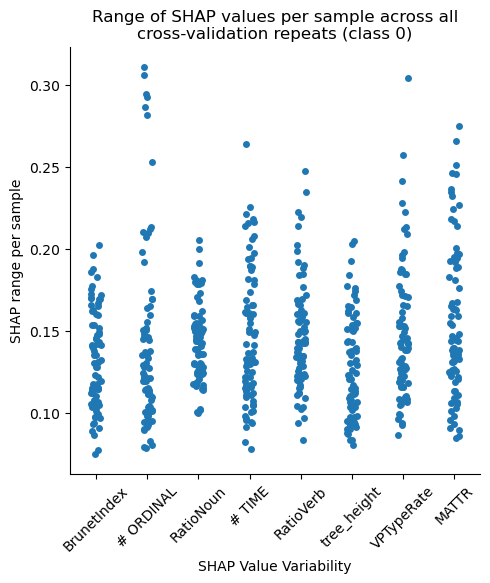

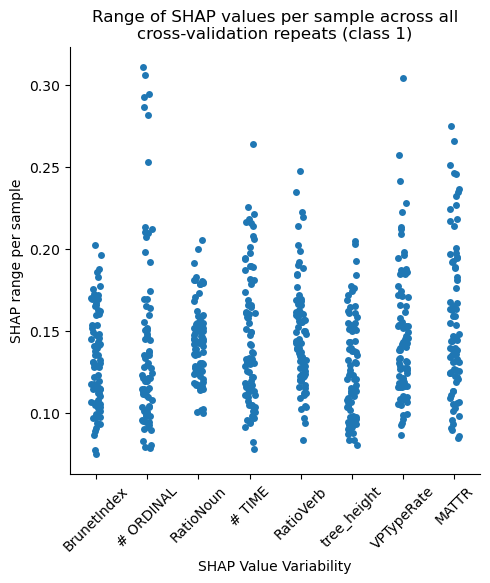

In [218]:
plot_ranges(X_ab42_exp, ab42_class_0[2], 0)
plot_ranges(X_ab42_exp, ab42_class_1[2], 1)